In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib.colors as mcolors
import numpy as np

In [3]:
path = '../data/processed_notebooks'
all_files = glob.glob(os.path.join(path, "*.csv"))

# 1. Load into a dictionary first
dfs = {os.path.basename(f).replace('_clean.csv', '').replace('.csv', ''): pd.read_csv(f) 
       for f in all_files}

# 2. Explicitly assign them (This fixes the Pylance 'Undefined' error)
calendar = dfs.get('calendar')
customers = dfs.get('customers')
products = dfs.get('products')
categories = dfs.get('product_categories')
subcategories = dfs.get('product_subcategories')
territories = dfs.get('territories')
sales = dfs.get('sales')
returns = dfs.get('returns')

print("✅ Variables explicitly defined.")

✅ Variables explicitly defined.


# Model Design

### Sales forecasts

In [4]:
# cols needed: order_date /

In [5]:
sales.head(3)

,Unnamed: 0,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity
0,0,2015-01-01,2001-09-21,SO45080,332,14657,1,1,1
1,1,2015-01-01,2001-12-05,SO45079,312,29255,4,1,1
2,2,2015-01-01,2001-10-29,SO45082,350,11455,9,1,1


In [6]:
# 1. Join Sales to Products, then to Subcategories
df_sales = sales[['OrderDate', 'OrderQuantity', 'ProductKey']].merge(
    products[['ProductKey', 'ProductSubcategoryKey']], 
    on='ProductKey', 
    how='left'
).merge(
    subcategories[['ProductSubcategoryKey', 'SubcategoryName']], 
    on='ProductSubcategoryKey', 
    how='left'
)

# 2. Select only our target columns
df_sales = df_sales[['OrderDate', 'SubcategoryName', 'OrderQuantity']]

In [7]:
df_sales

,OrderDate,SubcategoryName,OrderQuantity
0,2015-01-01,Road Bikes,1
1,2015-01-01,Road Bikes,1
2,2015-01-01,Mountain Bikes,1
3,2015-01-01,Road Bikes,1
4,2015-01-02,Road Bikes,1
...,...,...,...
56041,2017-06-30,Bottles and Cages,2
56042,2017-06-30,Bottles and Cages,1
56043,2017-06-30,Road Bikes,1
56044,2017-06-30,Tires and Tubes,2


### EDA

In [8]:
# 2. Update the dataframe to only include rows from August 1st, 2016 onward
df_sales = df_sales[df_sales['OrderDate'] >= '2016-08-01'].copy()

In [9]:
# 1. Ensure Date consistency
df_sales['OrderDate'] = pd.to_datetime(df_sales['OrderDate'])

# 2. Identify unique dimensions
unique_items = df_sales['SubcategoryName'].unique()
unique_dates = pd.date_range(start=df_sales['OrderDate'].min(), 
                             end=df_sales['OrderDate'].max(), freq='D')

# 3. Create the Dense Grid (Cartesian Product)
grid = pd.MultiIndex.from_product([unique_dates, unique_items], 
                                  names=['OrderDate', 'SubcategoryName'])
df_grid = pd.DataFrame(index=grid).reset_index()

# 4. Aggregate Transactions to Daily Totals
# This sums up the 50k transactions into daily item totals
df_daily_agg = df_sales.groupby(['OrderDate', 'SubcategoryName'])['OrderQuantity'].sum().reset_index()

# 5. Merge Grid with Sales
# We use 'left' join on the grid to ensure NO dates or items are lost
df_sales = pd.merge(df_grid, df_daily_agg, on=['OrderDate', 'SubcategoryName'], how='left')

# 6. Zero-Fill missing days
df_sales['OrderQuantity'] = df_sales['OrderQuantity'].fillna(0)

# Verification
expected_rows = len(unique_dates) * len(unique_items)
print(f"Unique Items: {len(unique_items)} | Unique Days: {len(unique_dates)}")
print(f"Final Rows: {len(df_sales)} (Expected: {expected_rows})")

Unique Items: 17 | Unique Days: 334
Final Rows: 5678 (Expected: 5678)


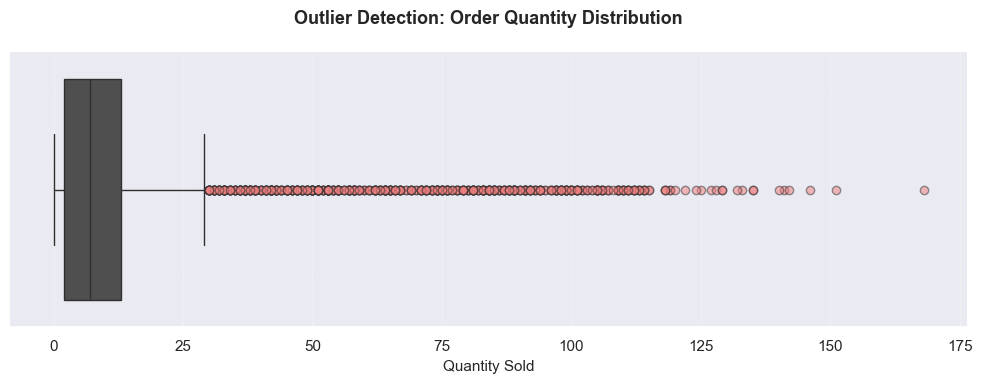

In [10]:
# Clean, professional boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_sales['OrderQuantity'], color='#4F4F4F', 
            flierprops={'marker': 'o', 'markerfacecolor': '#F08080', 'alpha': 0.5})

plt.title('Outlier Detection: Order Quantity Distribution', fontsize=13, fontweight='bold', pad=20)
plt.xlabel('Quantity Sold', fontsize=11)

# Aesthetic clean-up
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# 1. Calculate Quartiles
Q1 = df_sales['OrderQuantity'].quantile(0.25)
Q3 = df_sales['OrderQuantity'].quantile(0.75)

# 2. Calculate Interquartile Range (IQR)
IQR = Q3 - Q1

# 3. Define Upper Band
upper_band = Q3 + 1.5 * IQR

# 4. Count Outliers
outliers_count = len(df_sales[df_sales['OrderQuantity'] > upper_band])

print(f"IQR Upper Band: {upper_band}")
print(f"Total Outliers: {outliers_count}")

IQR Upper Band: 29.5
Total Outliers: 626


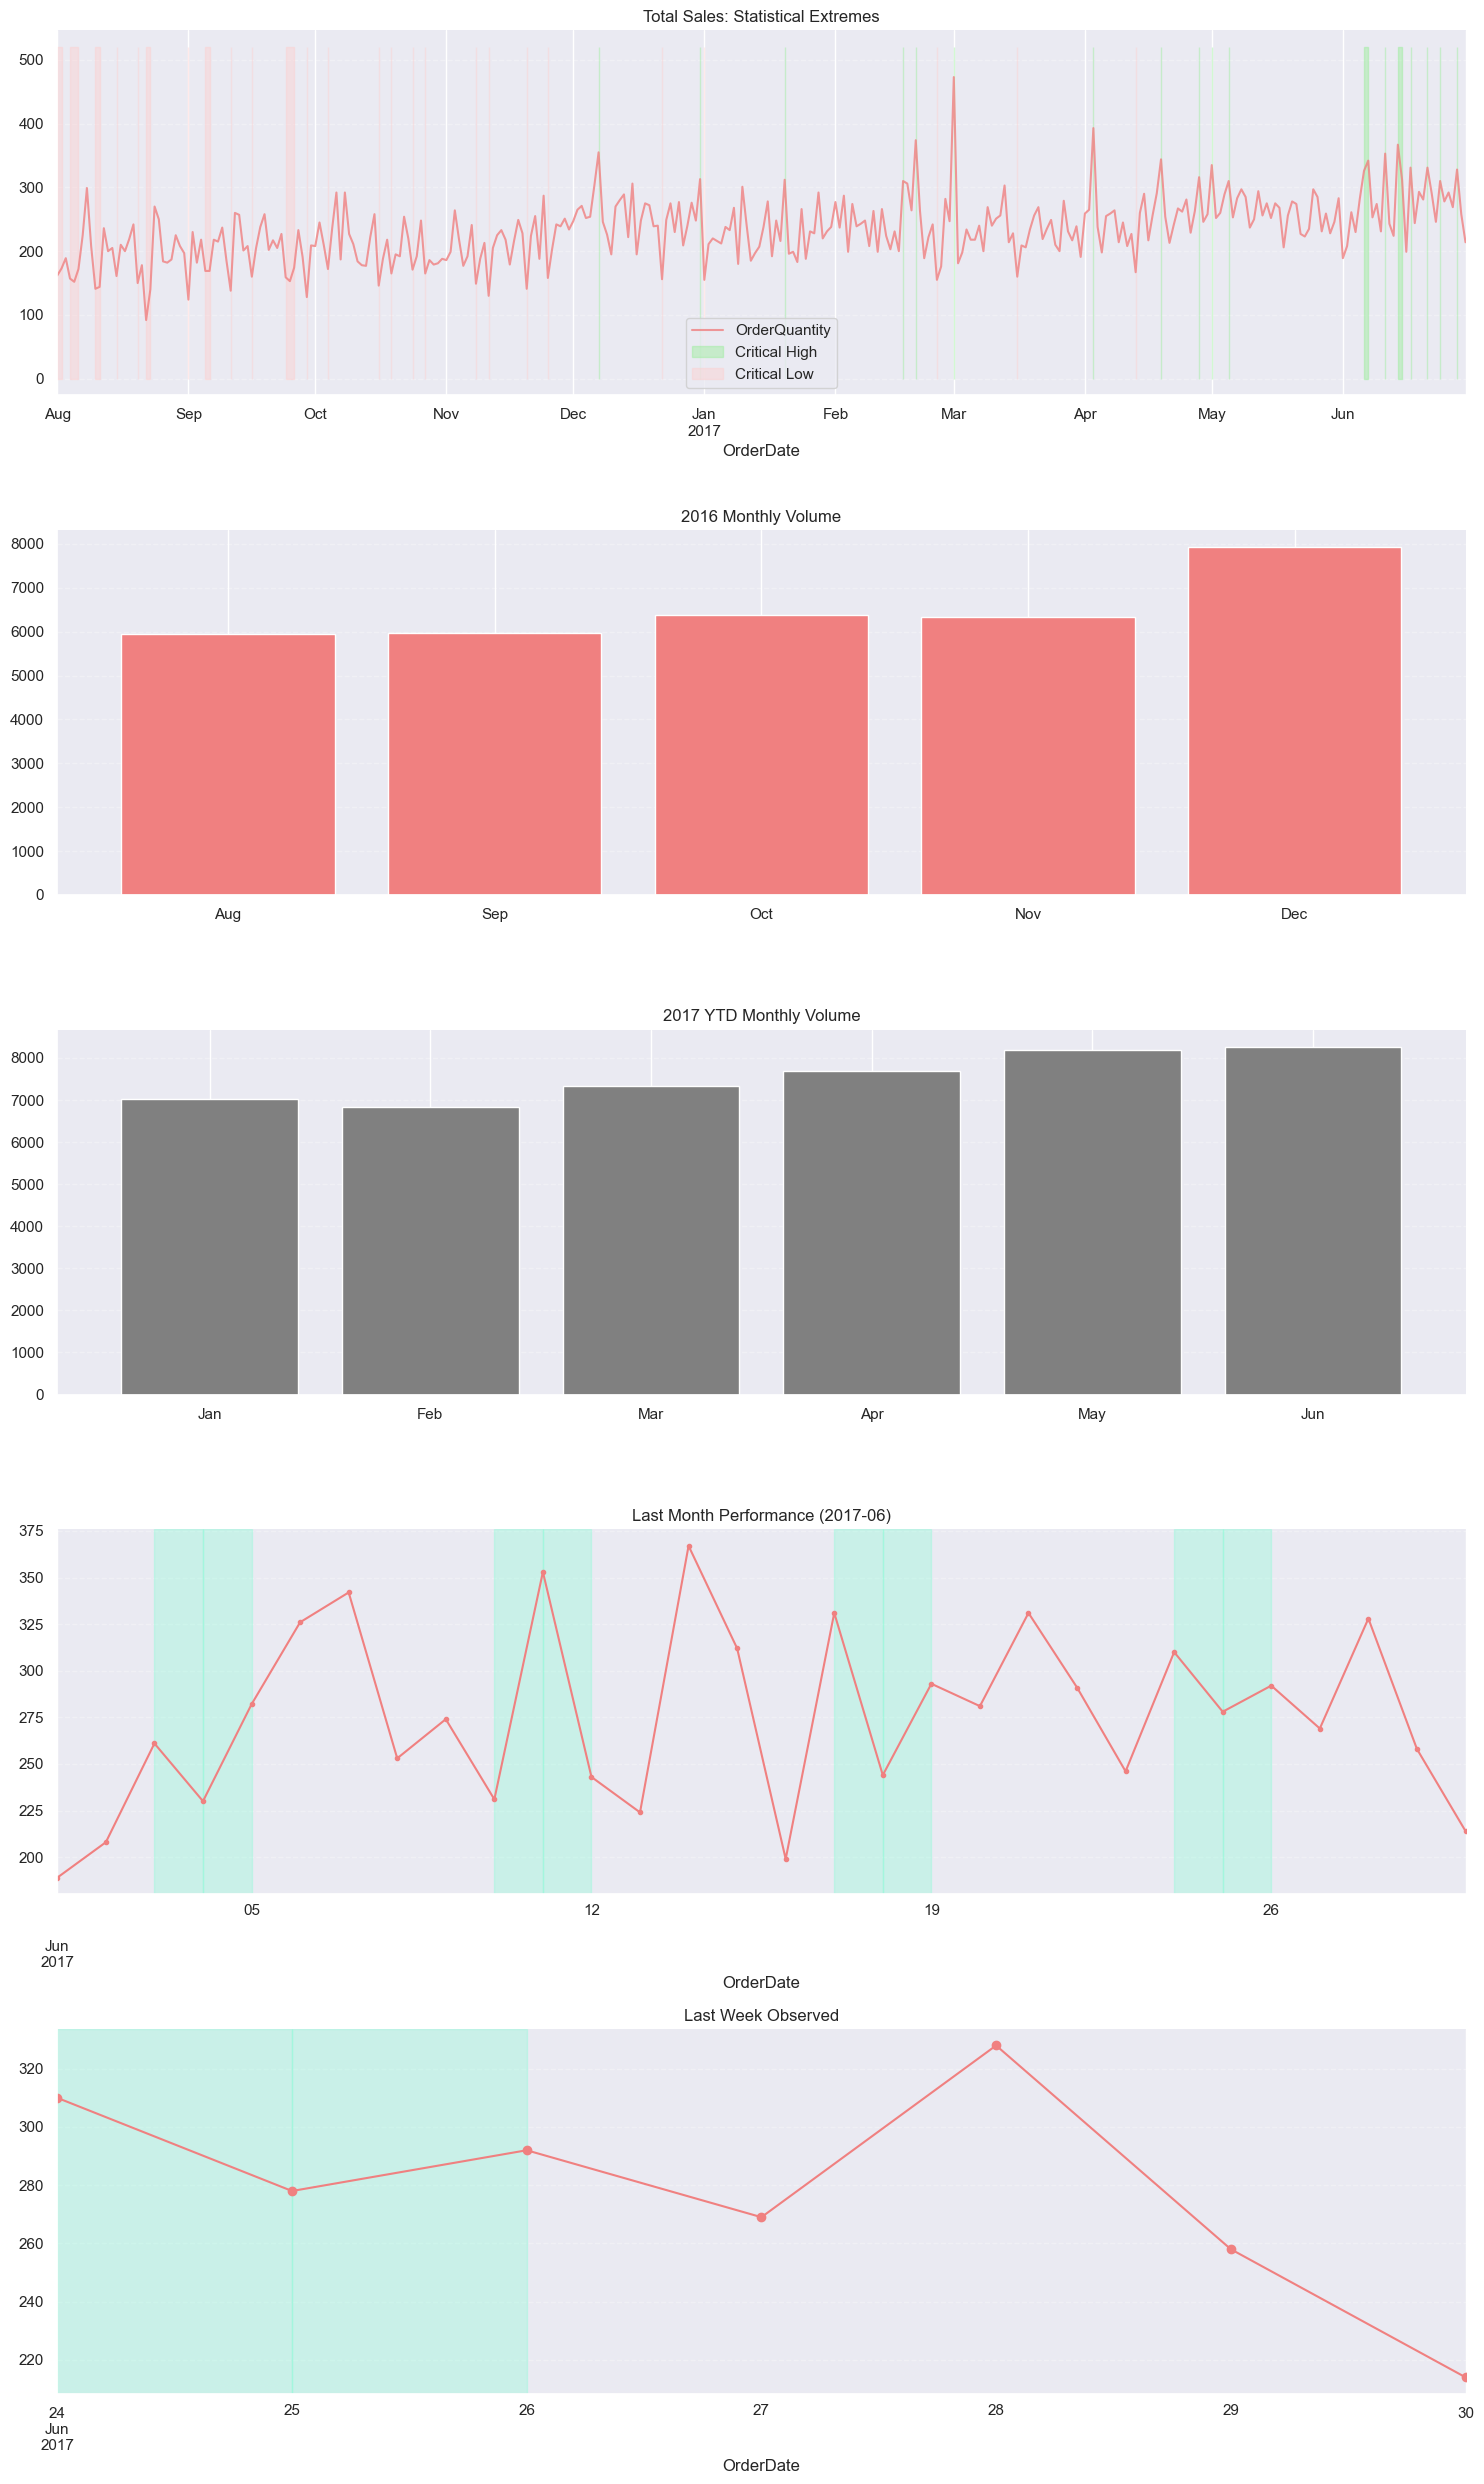

In [12]:
# 1. Prepare Daily Data - Aggregate all subcategories into one daily total
daily_sales = df_sales.groupby('OrderDate')['OrderQuantity'].sum()
# Resample 'D' ensures no gaps in the timeline for statistical calculations
daily_sales = daily_sales.resample('D').sum()

avg, std = daily_sales.mean(), daily_sales.std()
aqua_weekend = '#7FFFD4'
line_color = '#F08080'

# 2. Setup Plot (5 subplots)
fig, axes = plt.subplots(5, 1, figsize=(15, 25))

# --- Graph 1: Total Trend & Extremes ---
daily_sales.plot(ax=axes[0], color=line_color, alpha=0.8, title='Total Sales: Statistical Extremes')
# Shading areas based on Standard Deviation thresholds
axes[0].fill_between(daily_sales.index, 0, daily_sales.max()*1.1, 
                    where=(daily_sales > avg + 1.5*std), color='#90EE90', alpha=0.4, label='Critical High')
axes[0].fill_between(daily_sales.index, 0, daily_sales.max()*1.1, 
                    where=(daily_sales < avg - 1.2*std), color='#FFCCCB', alpha=0.4, label='Critical Low')
axes[0].legend()

# --- Graph 2: 2016 Monthly (Full Year) ---
# 'ME' stands for Month End frequency
sales_2016 = daily_sales[daily_sales.index.year == 2016].resample('ME').sum()
if not sales_2016.empty:
    labels_2016 = sales_2016.index.strftime('%b')
    axes[1].bar(labels_2016, sales_2016.values, color=line_color)
    axes[1].set_title('2016 Monthly Volume')

# --- Graph 3: 2017 Monthly (YTD) ---
sales_2017 = daily_sales[daily_sales.index.year == 2017].resample('ME').sum()
if not sales_2017.empty:
    labels_2017 = sales_2017.index.strftime('%b')
    axes[2].bar(labels_2017, sales_2017.values, color='#808080')
    axes[2].set_title('2017 YTD Monthly Volume')

# --- Graph 4: Last Month Observed ---
last_date = daily_sales.index.max()
last_month_data = daily_sales[(daily_sales.index.month == last_date.month) & 
                             (daily_sales.index.year == last_date.year)]
last_month_data.plot(ax=axes[3], color=line_color, marker='.', title=f'Last Month Performance ({last_date.strftime("%Y-%m")})')
# Highlight Weekends
for day in last_month_data.index:
    if day.weekday() >= 5:
        axes[3].axvspan(day, day + pd.Timedelta(days=1), color=aqua_weekend, alpha=0.3)

# --- Graph 5: Last Week Observed ---
last_week = daily_sales.tail(7)
last_week.plot(ax=axes[4], marker='o', color=line_color, title='Last Week Observed')
for day in last_week.index:
    if day.weekday() >= 5:
        axes[4].axvspan(day, day + pd.Timedelta(days=1), color=aqua_weekend, alpha=0.3)

# Aesthetic Formatting
for ax in axes:
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

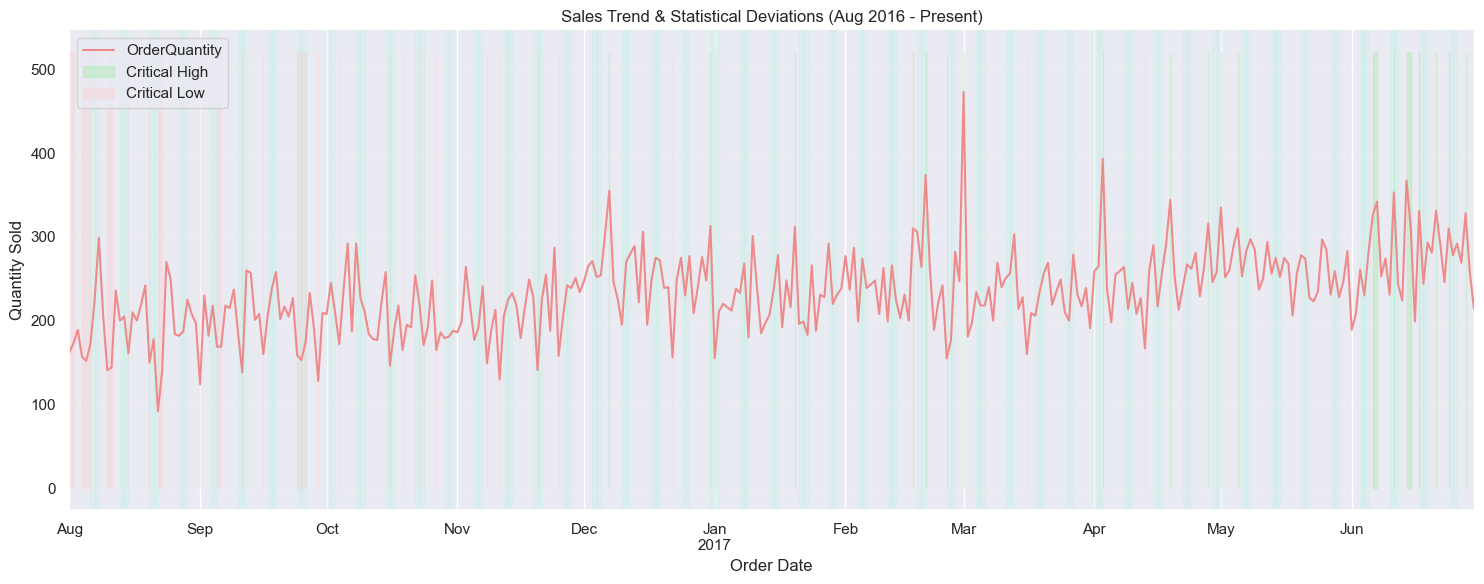

In [13]:
# 1. Slice the data from August 2016 onward
# Using the pre-aggregated daily_sales from the previous step
recent_sales = daily_sales['2016-08-01':]
recent_avg = recent_sales.mean()
recent_std = recent_sales.std()

# 2. Setup Plot
fig, ax = plt.subplots(figsize=(15, 6))
line_color, aqua_weekend = '#F08080', '#7FFFD4'

# --- Plot the Data ---
recent_sales.plot(ax=ax, color=line_color, alpha=0.9, linewidth=1.5, 
                  title='Sales Trend & Statistical Deviations (Aug 2016 - Present)')

# --- Highlight Extremes (Statistical Outliers) ---
# Highlighting spikes greater than 1.5 Standard Deviations
ax.fill_between(recent_sales.index, 0, recent_sales.max()*1.1, 
                where=(recent_sales > recent_avg + 1.5*recent_std), 
                color='#90EE90', alpha=0.3, label='Critical High')

# Highlighting dips lower than 1.2 Standard Deviations
ax.fill_between(recent_sales.index, 0, recent_sales.max()*1.1, 
                where=(recent_sales < recent_avg - 1.2*recent_std), 
                color='#FFCCCB', alpha=0.3, label='Critical Low')

# --- Highlight Weekends ---
# Use .unique() on dates to avoid redundant shading in dense data
for day in recent_sales.index:
    if day.weekday() >= 5:
        ax.axvspan(day, day + pd.Timedelta(days=1), color=aqua_weekend, alpha=0.1)

# Aesthetic Global Formatting
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.2)
ax.set_ylabel('Quantity Sold')
ax.set_xlabel('Order Date')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

+ don't see yearly trends or monthly so no moving avg or lags 365

+ item to item seasonal trends

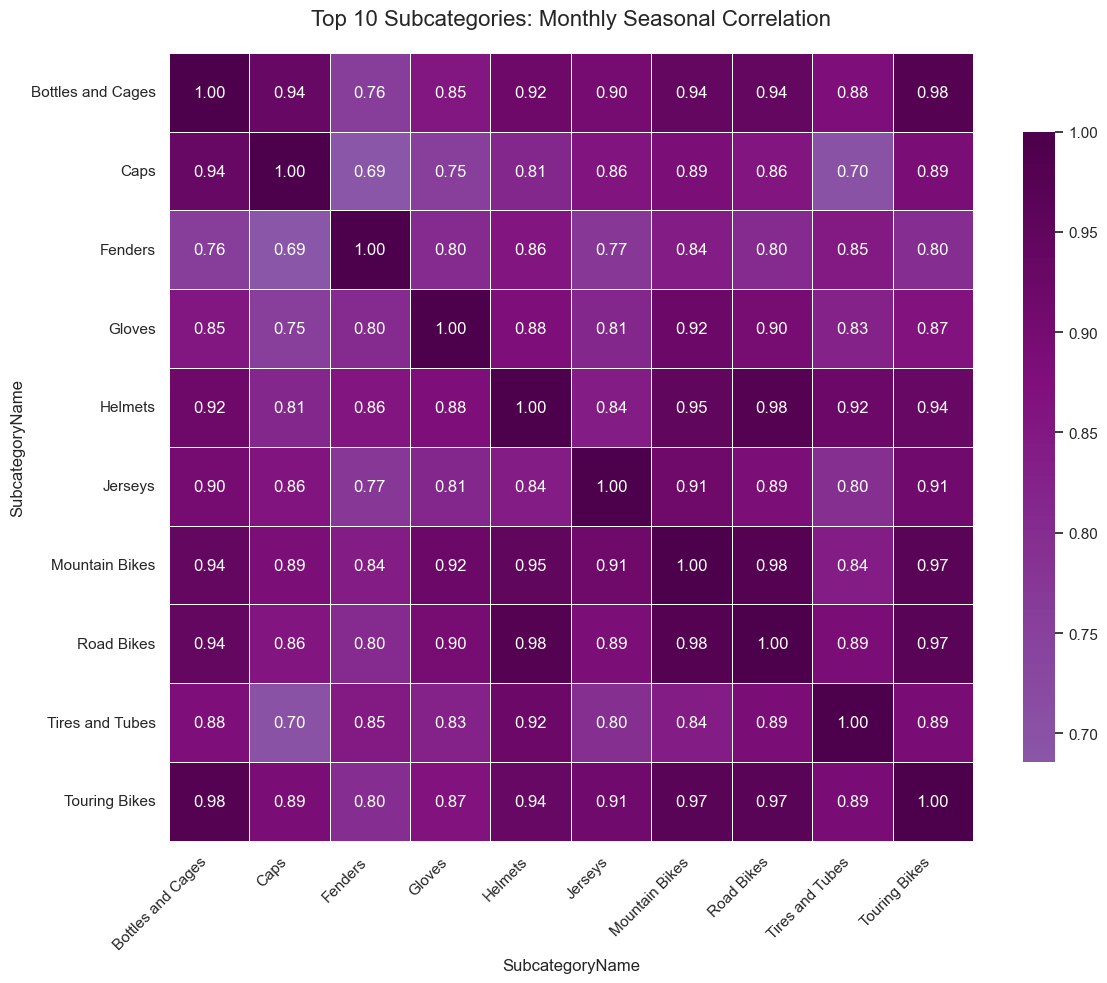

In [14]:
# 1. Filter for Top 10 Subcategories from our dense df_sales
top_subs = df_sales.groupby('SubcategoryName')['OrderQuantity'].sum().nlargest(10).index
df_filtered = df_sales[df_sales['SubcategoryName'].isin(top_subs)].copy()

# 2. Pivot: Aggregate into Monthly buckets to capture seasonality
# Note: Since OrderDate is already datetime, we access .dt directly
item_monthly_sales = df_filtered.pivot_table(
    index=df_filtered['OrderDate'].dt.to_period('M'), 
    columns='SubcategoryName', 
    values='OrderQuantity', 
    aggfunc='sum'
).fillna(0)

# 3. Compute Pearson Correlation Matrix
item_corr = item_monthly_sales.corr()

# 4. Plotting the Heatmap
plt.figure(figsize=(12, 10), facecolor='white')
sns.heatmap(item_corr, annot=True, fmt=".2f", cmap='BuPu', center=0.5, 
            linewidths=.5, cbar_kws={"shrink": .8})

plt.title("Top 10 Subcategories: Monthly Seasonal Correlation", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Detrended Seasonal Correlation (Growth Rates)')

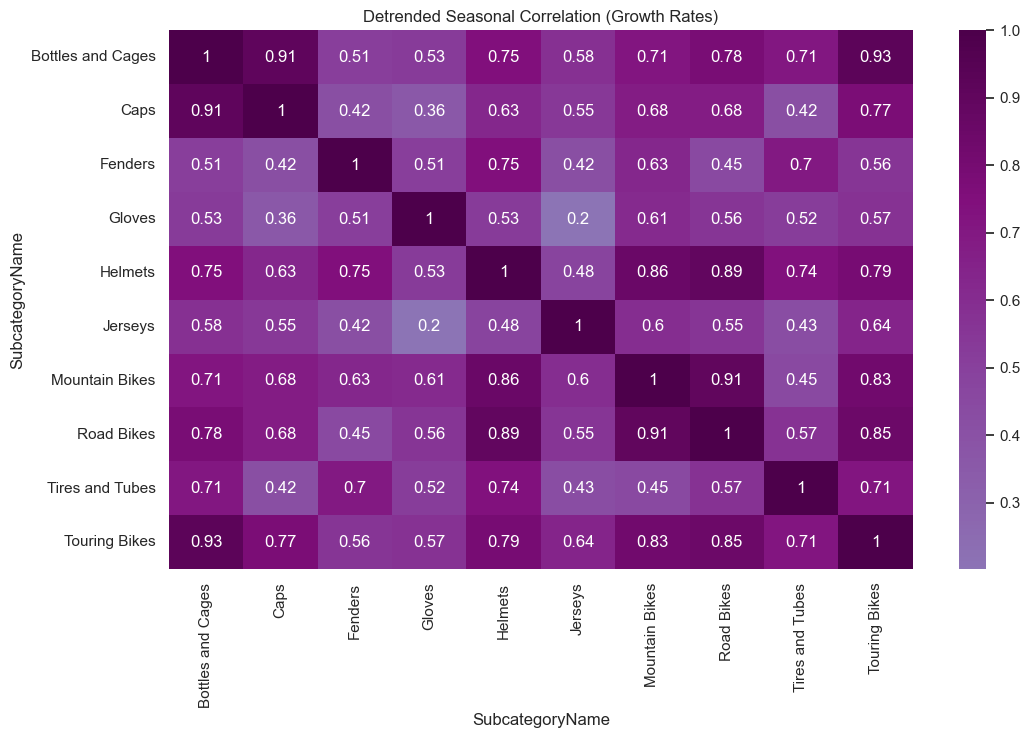

In [15]:
# Calculate correlation on the percentage change to remove the global growth trend
item_corr_detrended = item_monthly_sales.pct_change().corr()
plt.figure(figsize=(12, 7))
sns.heatmap(item_corr_detrended, annot=True, cmap='BuPu', center=0)
plt.title("Detrended Seasonal Correlation (Growth Rates)")

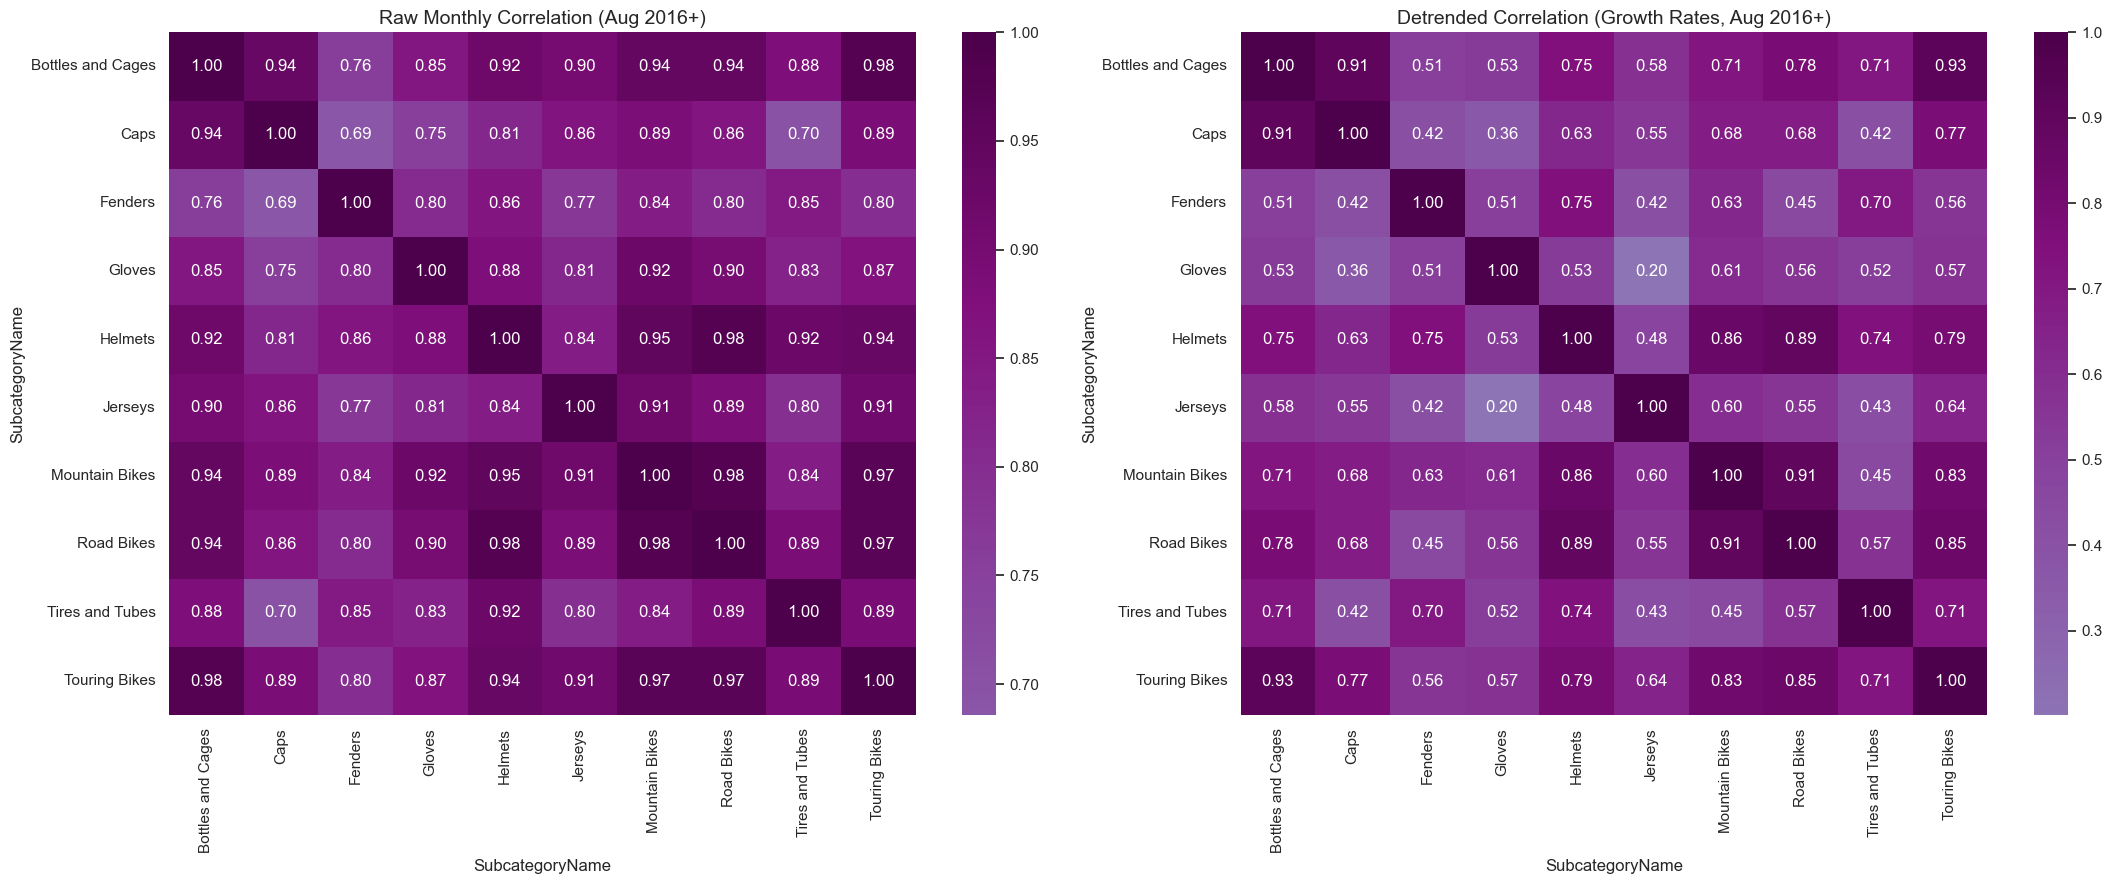

In [16]:
# 1. Slice data from 2016-08-01 onwards
df_recent = df_sales[df_sales['OrderDate'] >= '2016-08-01']

# 2. Get Top 10 Subcategories for this specific period
top_subs = df_recent.groupby('SubcategoryName')['OrderQuantity'].sum().nlargest(10).index
df_filtered = df_recent[df_recent['SubcategoryName'].isin(top_subs)]

# 3. Create Pivot Table (Use 'M' for Period index)
item_monthly = df_filtered.pivot_table(
    index=df_filtered['OrderDate'].dt.to_period('M'),
    columns='SubcategoryName',
    values='OrderQuantity',
    aggfunc='sum'
).fillna(0)

# 4. Calculate Raw vs Detrended Correlation
corr_raw = item_monthly.corr()
corr_detrended = item_monthly.pct_change().corr()

# 5. Plotting Side-by-Side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

# Heatmap 1: Raw Correlation
sns.heatmap(corr_raw, annot=True, fmt=".2f", cmap='BuPu', ax=ax1, center=0.5)
ax1.set_title("Raw Monthly Correlation (Aug 2016+)", fontsize=14)

# Heatmap 2: Detrended (Growth Rates)
# Using RdBu_r to highlight negative correlations in Red and positive in Blue
sns.heatmap(corr_detrended, annot=True, fmt=".2f", cmap='BuPu', ax=ax2, center=0)
ax2.set_title("Detrended Correlation (Growth Rates, Aug 2016+)", fontsize=14)

plt.tight_layout()
plt.show()

+ feature extraction

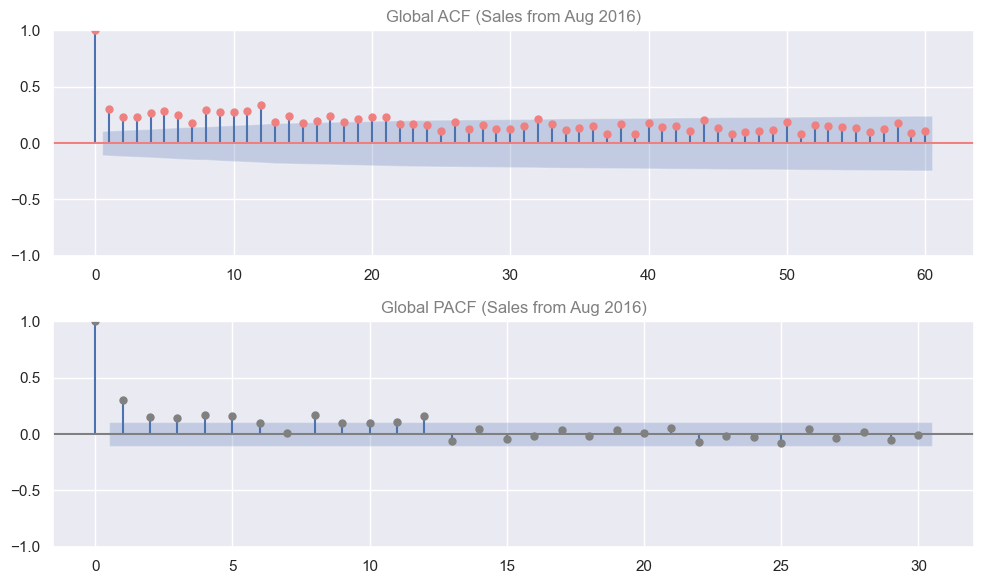

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Ensure we use the daily aggregated data
# Note: We use daily_sales defined earlier (Quantity sum by day)
series = daily_sales['2016-08-01':] 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# 2. ACF: Identifying the Seasonality (Weekly/Monthly cycles)
# We use 60 lags to see roughly 2 months of cycles
plot_acf(series, lags=60, ax=ax1, color='#F08080')
ax1.set_title('Global ACF (Sales from Aug 2016)', color='#808080')

# 3. PACF: Identifying Predictive Lags for Feature Engineering
# 30 lags is usually sufficient to see the 'immediate' impact
plot_pacf(series, lags=30, ax=ax2, color='#808080', method='ywm')
ax2.set_title('Global PACF (Sales from Aug 2016)', color='#808080')

plt.tight_layout()
plt.show()

+ pacf: 1/2 lags
+ acf: 7 moving avg/std

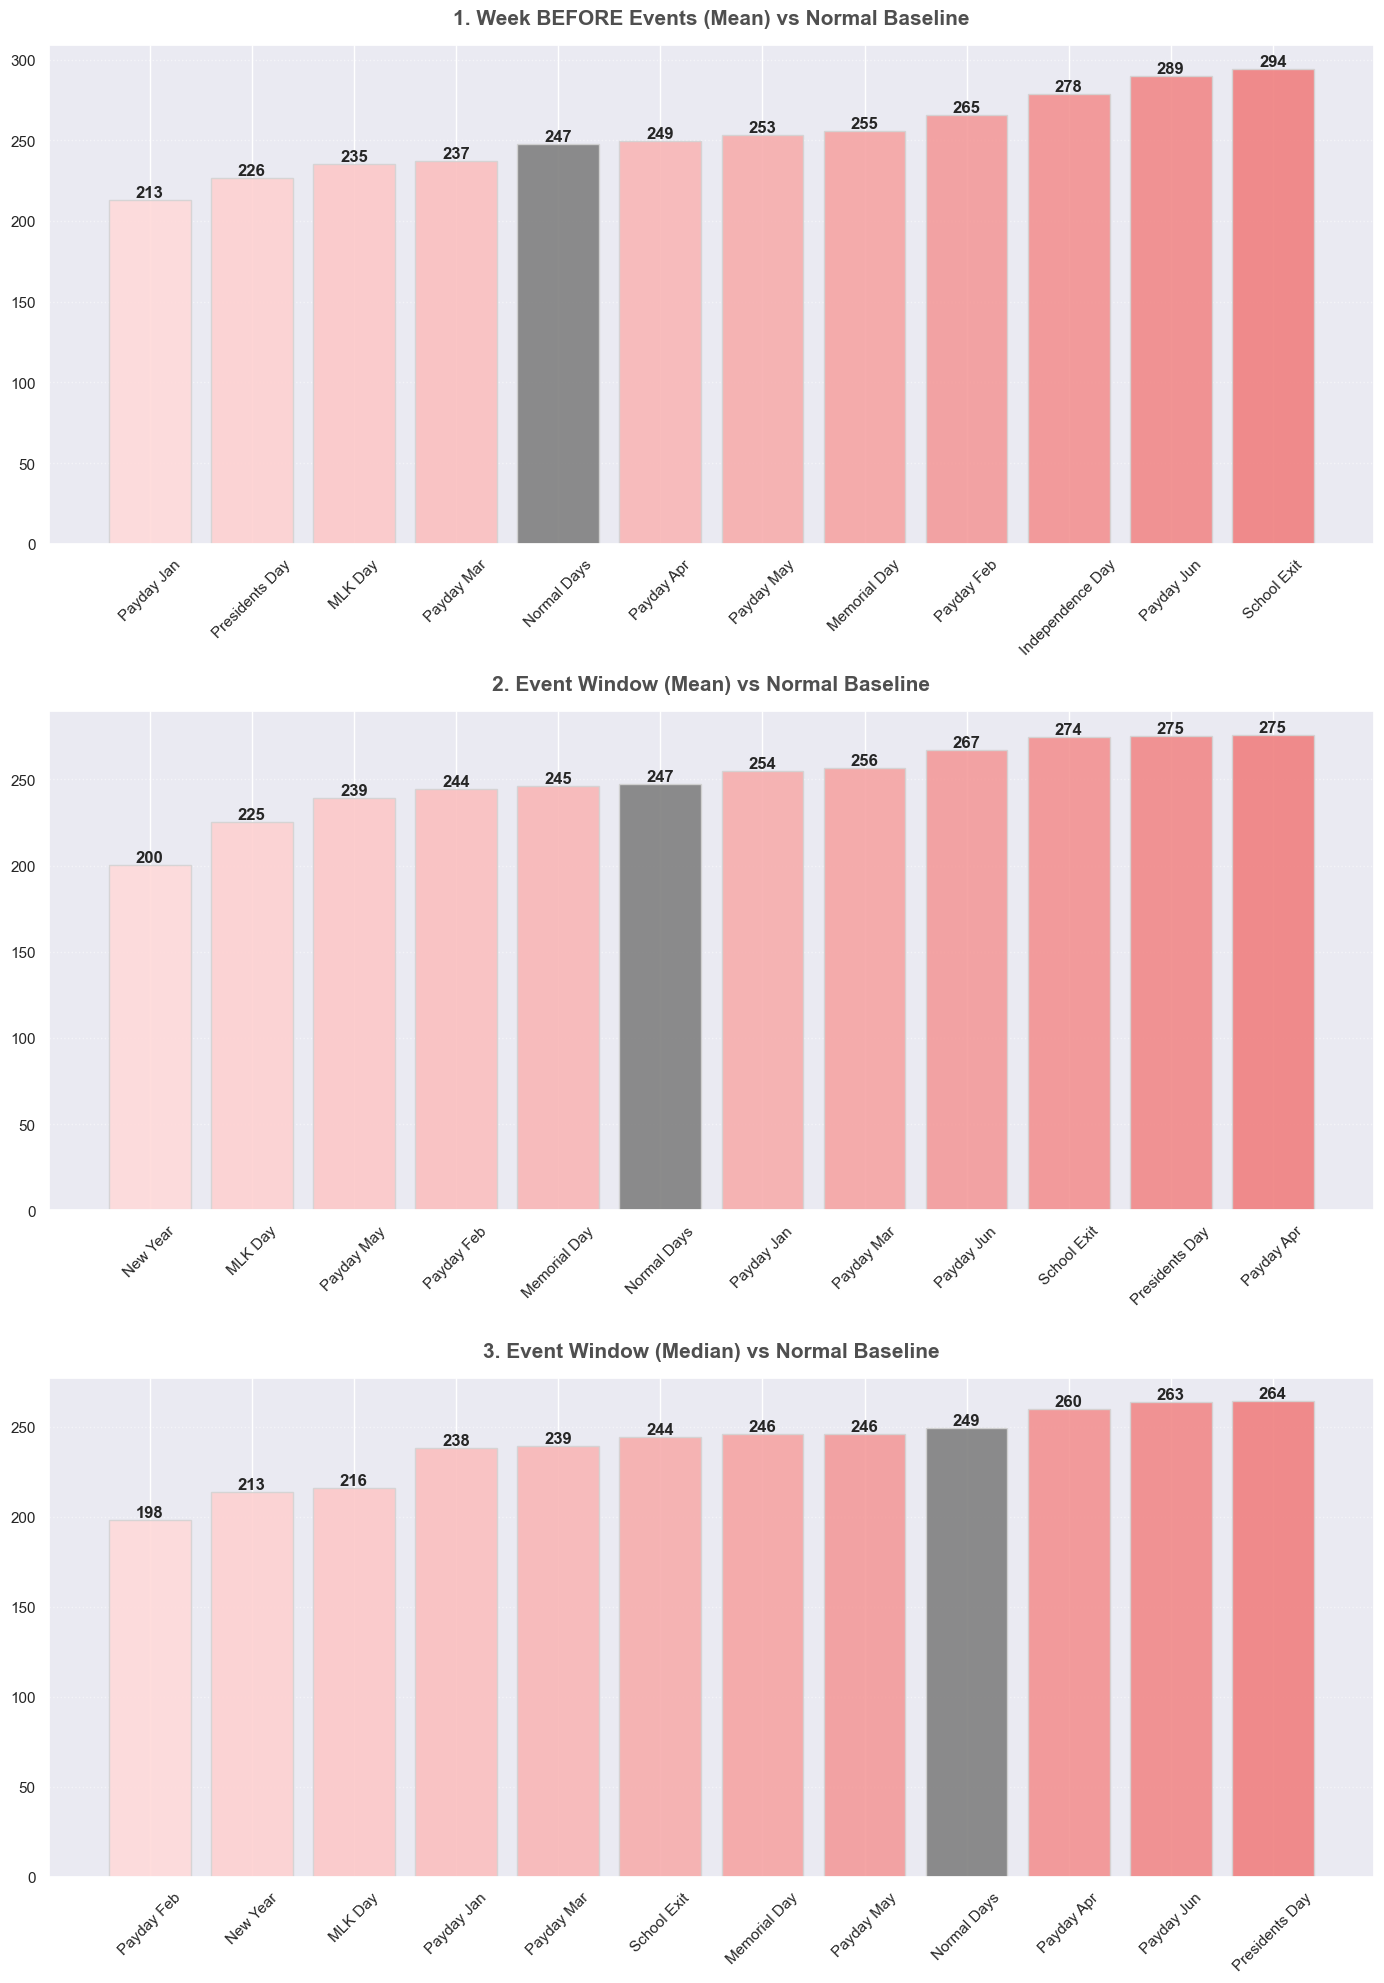

In [18]:
# 1. Aggregate daily sales for 2017 (our updated df_sales starts Aug 2016)
df_2017 = df_sales[df_sales['OrderDate'].dt.year == 2017].set_index('OrderDate')['OrderQuantity'].resample('D').sum()

# 2. Define Holidays & Special Events
events_2017 = {
    'New Year': '2017-01-01', 'MLK Day': '2017-01-16', 'Presidents Day': '2017-02-20',
    'Memorial Day': '2017-05-29', 'Independence Day': '2017-07-04', 
    'School Exit': '2017-06-15', # Typical start of summer break
}

# Add Paydays (Last day of every month observed in 2017)
for month_end in df_2017.index.to_series().resample('ME').max():
    events_2017[f'Payday {month_end.strftime("%b")}'] = month_end.strftime('%Y-%m-%d')

h_windows, p_windows, excluded = {}, {}, []

for name, d in events_2017.items():
    center = pd.to_datetime(d)
    # Holiday/Event: +/- 3 days | Pre-event: days -10 to -4
    h_s, h_e = center - pd.Timedelta(days=3), center + pd.Timedelta(days=3)
    p_s, p_e = center - pd.Timedelta(days=10), center - pd.Timedelta(days=4)
    
    h_data, p_data = df_2017[h_s:h_e], df_2017[p_s:p_e]
    if not h_data.empty: h_windows[name] = h_data
    if not p_data.empty: p_windows[name] = p_data
    excluded.extend(pd.date_range(p_s, h_e))

# 3. Calculate Baseline (Normal Days)
normal_days = df_2017.drop(pd.to_datetime(list(set(excluded))), errors='ignore')

# 4. Create Series for Plotting
s1 = pd.Series({**{n: w.mean() for n, w in p_windows.items()}, 'Normal Days': normal_days.mean()}).dropna().sort_values()
s2 = pd.Series({**{n: w.mean() for n, w in h_windows.items()}, 'Normal Days': normal_days.mean()}).dropna().sort_values()
s3 = pd.Series({**{n: w.median() for n, w in h_windows.items()}, 'Normal Days': normal_days.median()}).dropna().sort_values()

# 5. Gradient logic
red_cmap = mcolors.LinearSegmentedColormap.from_list("milk_red", ["#FFDADA", "#F08080"])

def get_bar_colors(series):
    n_items = len(series) - 1
    gradient = [red_cmap(i/max(1, n_items-1)) for i in range(n_items)]
    cols, g_idx = [], 0
    for label in series.index:
        if label == 'Normal Days': cols.append('#808080')
        else:
            cols.append(gradient[g_idx])
            g_idx += 1
    return cols

# 6. Plotting
fig, axes = plt.subplots(3, 1, figsize=(14, 20), facecolor='white')

def draw_formatted_bars(ax, data, title):
    bar_cols = get_bar_colors(data)
    bars = ax.bar(data.index, data.values, color=bar_cols, edgecolor='#D3D3D3', alpha=0.9)
    ax.set_title(title, fontsize=15, color='#4F4F4F', fontweight='bold', pad=15)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h, f'{int(h)}', ha='center', va='bottom', fontweight='bold')

draw_formatted_bars(axes[0], s1, '1. Week BEFORE Events (Mean) vs Normal Baseline')
draw_formatted_bars(axes[1], s2, '2. Event Window (Mean) vs Normal Baseline')
draw_formatted_bars(axes[2], s3, '3. Event Window (Median) vs Normal Baseline')

plt.tight_layout()
plt.show()

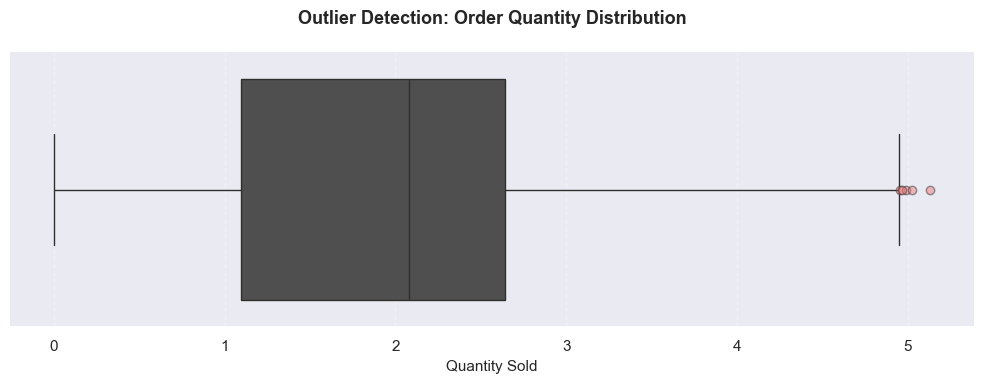

In [19]:
df_sales_log= df_sales.copy()
df_sales_log['OrderQuantity']= np.log(df_sales_log['OrderQuantity']+1)
# Clean, professional boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_sales_log['OrderQuantity'], color='#4F4F4F', 
            flierprops={'marker': 'o', 'markerfacecolor': '#F08080', 'alpha': 0.5})

plt.title('Outlier Detection: Order Quantity Distribution', fontsize=13, fontweight='bold', pad=20)
plt.xlabel('Quantity Sold', fontsize=11)

# Aesthetic clean-up
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

+ sales spike in holidays so will add them as features.

### Feature Engineering

In [84]:
from sklearn.preprocessing import OrdinalEncoder
from pandas.tseries.holiday import USFederalHolidayCalendar

def engineer_sales_features(df):
    data = df.copy()
    
    # 1. Target Transformation (Applied ONCE)
    # Since we train on log-scale, we transform the target here.
    data['OrderQuantity'] = np.log1p(data['OrderQuantity'])
    
    # 2. Ordinal Encoding for Subcategories
    encoder = OrdinalEncoder()
    data['Subcategory_Encoded'] = encoder.fit_transform(data[['SubcategoryName']])
    
    # 3. Temporal Features
    data['month'] = data['OrderDate'].dt.month
    data['dayofweek'] = data['OrderDate'].dt.dayofweek
    data['dayofyear'] = data['OrderDate'].dt.dayofyear
    data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)
    
    # Cyclical encoding for seasonality
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['dayofyear_sin'] = np.sin(2 * np.pi * data['dayofyear'] / 365)
    data['dayofyear_cos'] = np.cos(2 * np.pi * data['dayofyear'] / 365)
    
    # 4. Holiday Feature
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=data['OrderDate'].min(), end=data['OrderDate'].max())
    data['is_holiday'] = data['OrderDate'].isin(holidays).astype(int)
    
    # 5. Grouped Windowing (CRITICAL: Isolates each subcategory)
    # Sort ensures time flows correctly within each group
    data = data.sort_values(['SubcategoryName', 'OrderDate'])
    group = data.groupby('SubcategoryName')['OrderQuantity']
    
    # Lags (Shifted within groups to prevent item-to-item leakage)
    data['lag_1'] = group.shift(1)
    data['lag_7'] = group.shift(7)
    
    # Rolling Metrics
    data['rolling_median_7'] = group.transform(lambda x: x.rolling(7).median())
    data['moving_std_7'] = group.transform(lambda x: x.rolling(7).std())
    
    # Acceleration: Difference between yesterday and the weekly trend
    data['acceleration'] = data['lag_1'] - data['rolling_median_7'].shift(1)
    
    # 6. Interaction Features
    data['cat_weekend_inter'] = data['Subcategory_Encoded'] * data['is_weekend']

    # 7. Final Clean up
    # Fill NAs (from lags/rolling) with 0 and return
    return data.fillna(0)

# Apply the refined engineering
df_treated = engineer_sales_features(df_sales)

In [85]:
from sklearn.preprocessing import MinMaxScaler
# Sort by Date so the split is a clean "time cut" across all items
df_treated = df_treated.sort_values('OrderDate').reset_index(drop=True)

# Define X and y
drop_cols = ['OrderQuantity', 'OrderDate', 'SubcategoryName']
X = df_treated.drop(columns=[c for c in drop_cols if c in df_treated.columns])
y_log = df_treated['OrderQuantity']

# Chronological split (The last 20% of the year for the whole business)
split_idx = int(len(df_treated) * 0.8)

# Initial slices
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_log_raw, y_test_log_raw = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

# Scaling (Fit on Train, Transform Test)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train_raw)
X_test_scaled = scaler_x.transform(X_test_raw)

y_train_scaled = scaler_y.fit_transform(y_train_log_raw.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_log_raw.values.reshape(-1, 1))

### Model selection

In [70]:
import xgboost as xgb
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# 1. Feature & Target Preparation
# X and y are now derived from the zero-padded, expanded dataset
drop_cols = ['OrderQuantity', 'OrderDate', 'SubcategoryName']
X = df_treated.drop(columns=[c for c in drop_cols if c in df_treated.columns])
y_log = df_treated['OrderQuantity'] 

# 2. Optuna Objective 
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'random_state': 42,
        'eval_metric': 'rmse'
    }
    
    # TimeSeriesSplit prevents data leakage
    tscv = TimeSeriesSplit(n_splits=5)
    real_rmse_scores = []
    
    for train_idx, val_idx in tscv.split(X):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv_log, y_val_cv_log = y_log.iloc[train_idx], y_log.iloc[val_idx]
        
        model = xgb.XGBRegressor(**param)
        model.fit(X_train_cv, y_train_cv_log)
        
        # Validate on REAL Units (Inverse of log1p)
        preds_log = model.predict(X_val_cv)
        preds_real = np.expm1(preds_log)
        y_val_real = np.expm1(y_val_cv_log)
        
        real_rmse_scores.append(np.sqrt(mean_squared_error(y_val_real, preds_real)))
        
    return np.mean(real_rmse_scores)

# 3. Optimization Run
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective, n_trials=30)

# 4. Final Training and Evaluation
best_params = study_xgb.best_params
best_xgb = xgb.XGBRegressor(**best_params)

# Chronological Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_log, y_test_log = y_log.iloc[:split_idx], y_log.iloc[split_idx:]

# Final fit on training set
best_xgb.fit(X_train, y_train_log)

# Inference on Test Set
test_preds_log = best_xgb.predict(X_test)
test_preds_real = np.expm1(test_preds_log)
y_test_real = np.expm1(y_test_log)

# Final Result
final_rmse = np.sqrt(mean_squared_error(y_test_real, test_preds_real))
print(f"Final XGB RMSE (Real Scale): {final_rmse:.2f} Units")

[I 2026-02-24 10:23:26,692] A new study created in memory with name: no-name-91572482-2757-4b2c-8d39-a4a622486339
[I 2026-02-24 10:23:30,473] Trial 0 finished with value: 11.910601040315148 and parameters: {'n_estimators': 1483, 'max_depth': 6, 'learning_rate': 0.03585639946510975, 'subsample': 0.8653348753120178, 'colsample_bytree': 0.8323938085113876}. Best is trial 0 with value: 11.910601040315148.
[I 2026-02-24 10:23:31,859] Trial 1 finished with value: 11.878598769083533 and parameters: {'n_estimators': 666, 'max_depth': 5, 'learning_rate': 0.09779068433904416, 'subsample': 0.7255286657410422, 'colsample_bytree': 0.6176036634248488}. Best is trial 1 with value: 11.878598769083533.
[I 2026-02-24 10:23:35,841] Trial 2 finished with value: 12.409515149748952 and parameters: {'n_estimators': 828, 'max_depth': 8, 'learning_rate': 0.030757369827944345, 'subsample': 0.600835604356393, 'colsample_bytree': 0.8631788613603035}. Best is trial 1 with value: 11.878598769083533.
[I 2026-02-24 1

Final XGB RMSE (Real Scale): 32.93 Units


### Model Eval

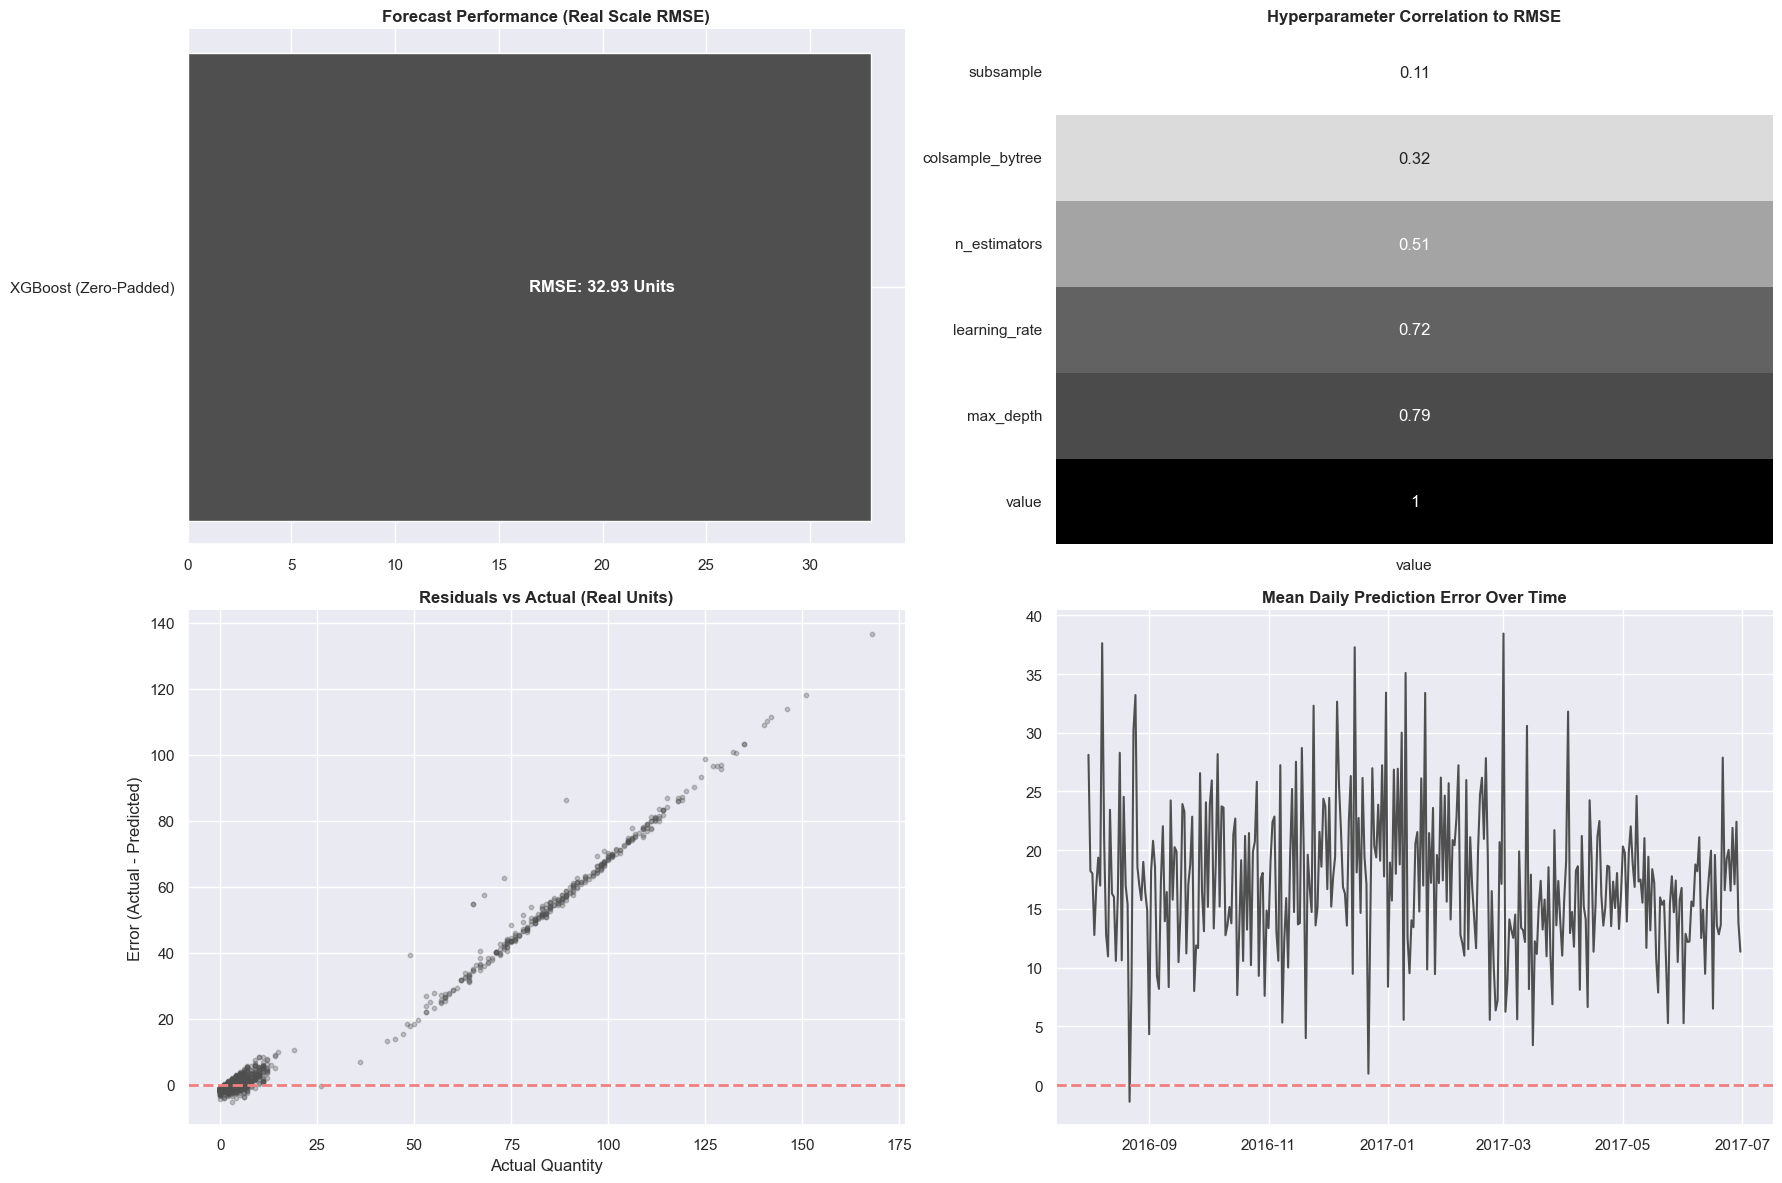


--- sMAPE by Subcategory (All Items) ---
    Subcategory     sMAPE
Tires and Tubes 93.445935
          Socks 83.816506
          Vests 79.085174
  Touring Bikes 36.058123


In [71]:
# 1. Align Data for Diagnostics
test_preds_log = best_xgb.predict(X_test)
test_preds_real = np.expm1(test_preds_log) 
y_test_real = np.expm1(y_test_log)

# Ensure the index matches our zero-padded df_treated
diagnostic_df = pd.DataFrame({
    'Actual': y_test_real.values,
    'Predicted': test_preds_real,
    'Error': y_test_real.values - test_preds_real,
    'Subcategory': df_treated.loc[y_test_log.index, 'SubcategoryName'].values
}, index=df_treated.loc[y_test_log.index, 'OrderDate'])

# 2. Reusable sMAPE Function
def calculate_smape_robust(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    numerator = np.abs(predicted - actual)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    return np.mean(np.divide(numerator, denominator, 
                               out=np.zeros_like(numerator), 
                               where=denominator != 0)) * 100

# 3. Create Dashboard Visuals
fig = plt.figure(figsize=(18, 12), facecolor='white')
gs = fig.add_gridspec(2, 2)

# Subplot 1: RMSE (Real Scale)
ax_rmse = fig.add_subplot(gs[0, 0])
rmse_val = np.sqrt(mean_squared_error(diagnostic_df['Actual'], diagnostic_df['Predicted']))
ax_rmse.barh(['XGBoost (Zero-Padded)'], [rmse_val], color='#4F4F4F', height=0.4)
ax_rmse.text(rmse_val/2, 0, f'RMSE: {rmse_val:.2f} Units', color='white', va='center', fontweight='bold')
ax_rmse.set_title('Forecast Performance (Real Scale RMSE)', fontweight='bold')
ax_rmse.spines[['top', 'right']].set_visible(False)

# Subplot 2: Optuna Parameter Correlation
ax_corr = fig.add_subplot(gs[0, 1])
optuna_df = study_xgb.trials_dataframe()
optuna_df = optuna_df.rename(columns={c: c.replace('params_', '') for c in optuna_df.columns})
cols = [c for c in best_params.keys() if c in optuna_df.columns] + ['value']
sns.heatmap(optuna_df[cols].corr()[['value']].sort_values(by='value'), 
            annot=True, cmap='Greys', ax=ax_corr, cbar=False)
ax_corr.set_title('Hyperparameter Correlation to RMSE', fontweight='bold')

# Subplot 3: Residuals vs Actuals

ax_res = fig.add_subplot(gs[1, 0])
ax_res.scatter(diagnostic_df['Actual'], diagnostic_df['Error'], alpha=0.3, color='#4F4F4F', s=10)
ax_res.axhline(0, color='#F08080', linestyle='--', lw=2)
ax_res.set_title("Residuals vs Actual (Real Units)", fontweight='bold')
ax_res.set_xlabel("Actual Quantity")
ax_res.set_ylabel("Error (Actual - Predicted)")
ax_res.spines[['top', 'right']].set_visible(False)

# Subplot 4: Time-Series Error
ax_time = fig.add_subplot(gs[1, 1])
daily_err = diagnostic_df['Error'].resample('D').mean()
ax_time.plot(daily_err.index, daily_err.values, color='#4F4F4F', lw=1.5)
ax_time.axhline(0, color='#F08080', linestyle='--', lw=2)
ax_time.set_title("Mean Daily Prediction Error Over Time", fontweight='bold')
ax_time.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# 4. SUB-CATEGORY BREAKDOWN
print("\n--- sMAPE by Subcategory (All Items) ---")
category_results = []
for cat, group in diagnostic_df.groupby('Subcategory'):
    val = calculate_smape_robust(group['Actual'], group['Predicted'])
    category_results.append({'Subcategory': cat, 'sMAPE': val})

category_stats = pd.DataFrame(category_results).sort_values(by='sMAPE', ascending=False)
print(category_stats.to_string(index=False))

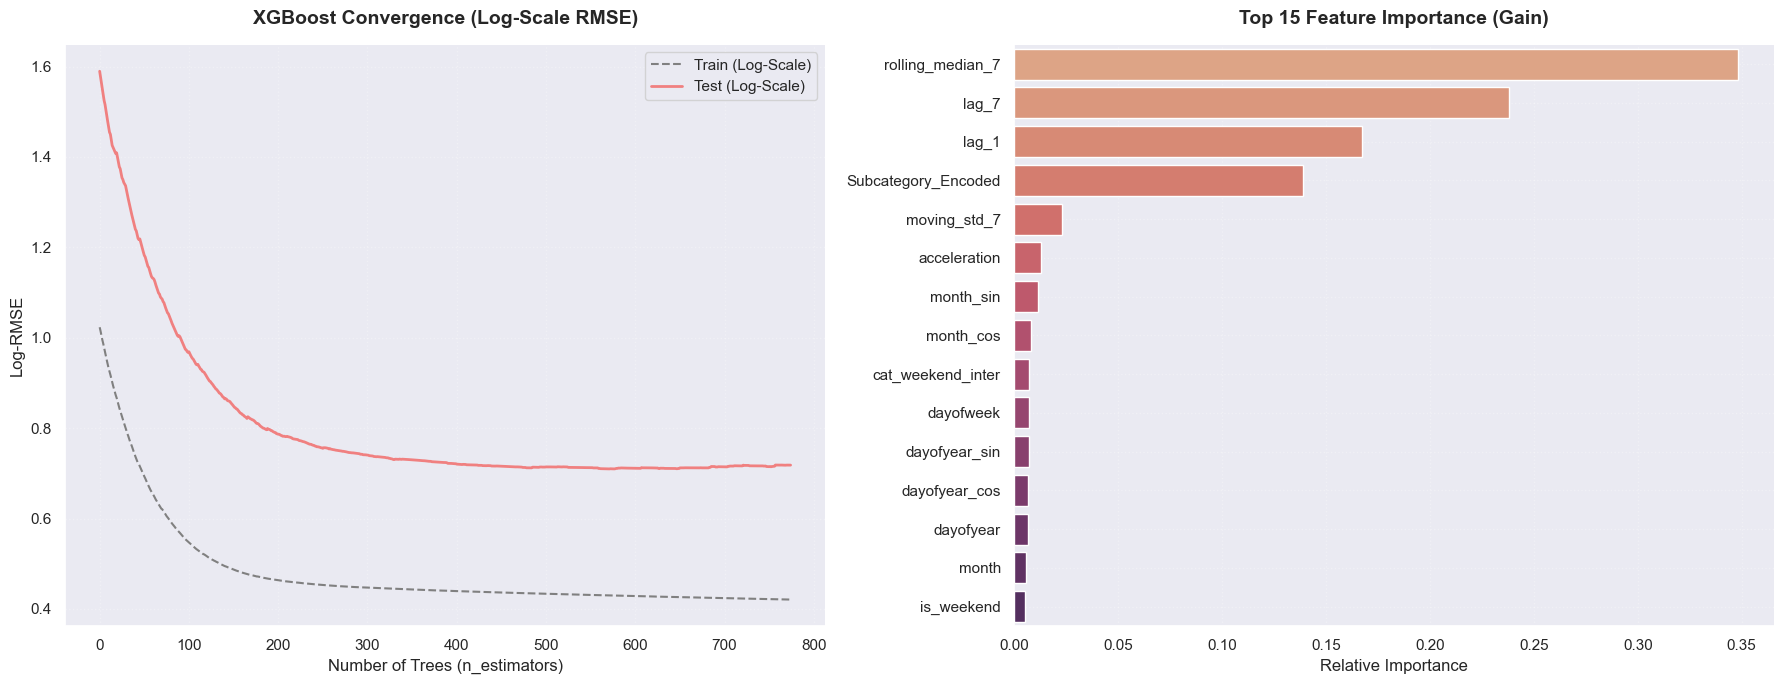

In [72]:
# 1. Update Model with Metric and Fit
best_xgb.set_params(eval_metric="rmse") 

# Using the padded 80/20 split
eval_set = [(X_train, y_train_log), (X_test, y_test_log)]
best_xgb.fit(X_train, y_train_log, eval_set=eval_set, verbose=False)

results = best_xgb.evals_result()

# 2. Extract Feature Importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 7), facecolor='white')
line_color, val_color = '#F08080', '#808080'

# --- Left Subplot: Learning Curve ---
epochs = len(results['validation_0']['rmse'])
axes[0].plot(range(epochs), results['validation_0']['rmse'], label='Train (Log-Scale)', color=val_color, linestyle='--')
axes[0].plot(range(epochs), results['validation_1']['rmse'], label='Test (Log-Scale)', color=line_color, linewidth=2)
axes[0].set_title('XGBoost Convergence (Log-Scale RMSE)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Number of Trees (n_estimators)')
axes[0].set_ylabel('Log-RMSE')
axes[0].legend()

# --- Right Subplot: Feature Importance ---
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), 
            ax=axes[1], hue='Feature', palette='flare', legend=False)
axes[1].set_title('Top 15 Feature Importance (Gain)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Relative Importance')
axes[1].set_ylabel('')

for ax in axes:
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(axis='both', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()

In [73]:
# 1. Define Robust sMAPE Function
def calculate_smape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    numerator = np.abs(predicted - actual)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    
    # Ensures numerical stability for zero-sales days
    # If both actual and predicted are 0, error is 0.
    return np.mean(np.divide(numerator, denominator, 
                             out=np.zeros_like(numerator), 
                             where=denominator != 0)) * 100

# 2. Reversion Step
# Reverting from log1p scale to original sales units
test_preds_real = np.expm1(test_preds_log) 
y_test_real = np.expm1(y_test_log)

# 3. Final Metric Calculation
# RMSE (Root Mean Squared Error) penalizes large outliers heavily
rmse = np.sqrt(mean_squared_error(y_test_real, test_preds_real))
# sMAPE (Symmetric Mean Absolute Percentage Error) provides a relative % error
test_smape = calculate_smape(y_test_real, test_preds_real)

# 4. Output Results
print("--- Final Model Evaluation (Real Scale) ---")
print(f"RMSE:  {rmse:.2f} Units")
print(f"sMAPE: {test_smape:.2f}%")

--- Final Model Evaluation (Real Scale) ---
RMSE:  32.93 Units
sMAPE: 71.21%


In [74]:
# 1. Calculate the counts
zero_sales_count = (df_sales['OrderQuantity'] == 0).sum()
positive_sales_count = (df_sales['OrderQuantity'] > 0).sum()
total_records = len(df_sales)

# 2. Create a summary table
sales_sparsity = pd.DataFrame({
    'Metric': ['Zero Sales Days', 'Positive Sales Days'],
    'Count': [zero_sales_count, positive_sales_count],
    'Percentage': [
        f"{(zero_sales_count / total_records) * 100:.2f}%",
        f"{(positive_sales_count / total_records) * 100:.2f}%"
    ]
})

print("--- Data Sparsity Analysis ---")
print(sales_sparsity.to_string(index=False))

--- Data Sparsity Analysis ---
             Metric  Count Percentage
    Zero Sales Days    550      9.69%
Positive Sales Days   5128     90.31%


In [75]:
import mlflow
import mlflow.xgboost
import os
import joblib

# 1. Setup path
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

# 2. Start MLflow Run
mlflow.set_experiment("AdventureWorks_Sales_Forecasting")

with mlflow.start_run(run_name="XGBoost_Log_Transformed"):
    # Log parameters from your best Optuna study
    mlflow.log_params(best_params)
    
    # Log the final metrics
    mlflow.log_metric("rmse", final_rmse)
    mlflow.log_metric("smape", test_smape)
    
    # 3. Save model using MLflow (for model versioning and deployment)
    mlflow.xgboost.log_model(best_xgb, artifact_path="model")
    
    # 4. Save as a standard .pkl file for quick local loading
    model_path = os.path.join(model_dir, "xgb_sales_model.pkl")
    joblib.dump(best_xgb, model_path)
    
    print(f"✅ Model saved locally to: {model_path}")
    print(f"✅ Model tracked in MLflow.")

2026/02/24 10:24:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Model saved locally to: ../models\xgb_sales_model.pkl
✅ Model tracked in MLflow.


### Trying deep learning


In [86]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

# 1. SORT BY DATE FIRST
# This ensures the 80/20 split captures the same timeframe for ALL 17 items
df_treated = df_treated.sort_values('OrderDate').reset_index(drop=True)

# 2. Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Define X and y from the sorted dataframe
drop_cols = ['OrderQuantity', 'OrderDate', 'SubcategoryName']
X_df = df_treated.drop(columns=[c for c in drop_cols if c in df_treated.columns])
y_series = df_treated['OrderQuantity']

X_scaled = scaler_x.fit_transform(X_df)
y_scaled = scaler_y.fit_transform(y_series.values.reshape(-1, 1))

# 3. Fixed Sequence Generation (Global Context)
def create_global_sequences(features, target, df_ref, window=7):
    X_seq, y_seq, indices = [], [], []
    
    # Loop through each subcategory to prevent history bleeding
    for cat in df_ref['SubcategoryName'].unique():
        cat_mask = (df_ref['SubcategoryName'] == cat)
        f_cat = features[cat_mask.values]
        t_cat = target[cat_mask.values]
        idx_cat = df_ref.index[cat_mask]
        
        # Sliding window within the item's specific timeline
        for i in range(window, len(f_cat)):
            X_seq.append(f_cat[i-window:i])
            y_seq.append(t_cat[i])
            indices.append(idx_cat[i]) # Track the original index for the report
            
    return torch.tensor(np.array(X_seq), dtype=torch.float32), \
           torch.tensor(np.array(y_seq), dtype=torch.float32), \
           indices

# 4. Split and Generate
split_idx = int(len(df_treated) * 0.8)

# Create sequences for the training block (0-80%) and test block (80-100%)
X_train_seq, y_train_seq, _ = create_global_sequences(
    X_scaled[:split_idx], y_scaled[:split_idx], df_treated.iloc[:split_idx]
)
X_test_seq, y_test_seq, test_indices_aligned = create_global_sequences(
    X_scaled[split_idx:], y_scaled[split_idx:], df_treated.iloc[split_idx:]
)

print(f"Train sequences: {X_train_seq.shape}") # Should be ~14,000+
print(f"Test sequences: {X_test_seq.shape}")   # Should be ~3,500+

Train sequences: torch.Size([4423, 7, 16])
Test sequences: torch.Size([1017, 7, 16])


In [87]:
from torch.utils.data import DataLoader, TensorDataset

# 1. Define the Model Class
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, layers, dropout=0.2):
        super().__init__()
        # input_dim: number of features (X_train_seq.shape[2])
        # hidden_dim: size of the "memory" state
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers, 
                            batch_first=True, 
                            dropout=dropout if layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # x shape: (batch, window_size, features)
        _, (hn, _) = self.lstm(x)
        # hn[-1] is the final hidden state of the deepest layer
        return self.fc(hn[-1])

# 2. Define the Objective Function for Optuna
def objective(trial):
    # Search space for hyperparameters
    h_dim = trial.suggest_int('hidden_dim', 32, 256)
    n_layers = trial.suggest_int('layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    drop_out = trial.suggest_float('dropout', 0.1, 0.4)
    
    # Load the synchronized sequences
    train_loader = DataLoader(TensorDataset(X_train_seq, y_train_seq), 
                              batch_size=batch_size, shuffle=True)
    
    model = LSTMRegressor(X_train_seq.shape[2], h_dim, n_layers, drop_out)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Training Loop
    model.train()
    for epoch in range(50):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            out = model(batch_x)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            
        # Validation for Pruning (Calculated on the Scaled Log data)
        model.eval()
        with torch.no_grad():
            preds = model(X_test_seq)
            val_rmse = torch.sqrt(criterion(preds, y_test_seq)).item()
            
        # Report progress to Optuna
        trial.report(val_rmse, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return val_rmse

# 3. Execution: Minimize RMSE
study_lstm = optuna.create_study(direction='minimize', 
                                 pruner=optuna.pruners.MedianPruner())
study_lstm.optimize(objective, n_trials=30)

[I 2026-02-24 10:36:34,578] A new study created in memory with name: no-name-1f3a3d29-45bf-4b0f-937a-9fa85b31e451
[I 2026-02-24 10:36:44,459] Trial 0 finished with value: 0.0921594500541687 and parameters: {'hidden_dim': 56, 'layers': 1, 'lr': 0.0004420838412825789, 'batch_size': 64, 'dropout': 0.1024157975948477}. Best is trial 0 with value: 0.0921594500541687.
[I 2026-02-24 10:37:12,984] Trial 1 finished with value: 0.09215280413627625 and parameters: {'hidden_dim': 64, 'layers': 2, 'lr': 0.00011459898873372916, 'batch_size': 32, 'dropout': 0.1305124045910394}. Best is trial 1 with value: 0.09215280413627625.
[I 2026-02-24 10:37:43,367] Trial 2 finished with value: 0.09508258104324341 and parameters: {'hidden_dim': 73, 'layers': 2, 'lr': 0.0018705696209497548, 'batch_size': 32, 'dropout': 0.24993119859747454}. Best is trial 1 with value: 0.09215280413627625.
[I 2026-02-24 10:38:04,889] Trial 3 finished with value: 0.09173771739006042 and parameters: {'hidden_dim': 166, 'layers': 1, '

In [88]:
# 1. Extract best params
best_params = study_lstm.best_params

# Initialize model with optimized architecture
best_lstm = LSTMRegressor(
    X_train_seq.shape[2], 
    best_params['hidden_dim'], 
    best_params['layers'],
    dropout=best_params['dropout']
)

optimizer = torch.optim.Adam(best_lstm.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

train_losses, val_losses = [], []

# 2. Retrain for 100 epochs using the best parameters
for epoch in range(100):
    best_lstm.train()
    optimizer.zero_grad()
    out = best_lstm(X_train_seq)
    loss = criterion(out, y_train_seq)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    best_lstm.eval()
    with torch.no_grad():
        v_out = best_lstm(X_test_seq)
        v_loss = criterion(v_out, y_test_seq)
        val_losses.append(v_loss.item())

# 3. FINAL EVALUATION (Inverse Scaling & Inverse Log)
best_lstm.eval()
with torch.no_grad():
    # 1. Get raw model output (Scaled Log)
    preds_scaled = best_lstm(X_test_seq).numpy()
    
    # 2. Reverse MinMaxScaler (Back to Log Scale)
    preds_log = scaler_y.inverse_transform(preds_scaled)
    actual_log = scaler_y.inverse_transform(y_test_seq.numpy())
    
    # 3. Reverse Log1p (Back to Actual Sales Units)
    preds_final = np.expm1(preds_log)
    actual_final = np.expm1(actual_log)
    
    # 4. Calculate Final Real-World RMSE
    # This reflects the average unit error per subcategory per day
    final_rmse = np.sqrt(np.mean((preds_final - actual_final)**2))
    print(f"Final Project RMSE: {final_rmse:.2f} units")

Final Project RMSE: 22.74 units


In [95]:
def get_permutation_importance(model, X_seq, y_actual_real, scaler_y, base_preds_real):
    model.eval()
    # 1. Establish the 'Normal' performance baseline
    baseline_rmse = np.sqrt(mean_squared_error(y_actual_real, base_preds_real))
    importances = []
    
    # 2. Iterate through every feature in the sequence
    for i in range(X_seq.shape[2]):
        X_temp = X_seq.clone()
        
        # 3. Destroy the signal for feature 'i' by shuffling it
        # This keeps the values but breaks their relationship to the target
        X_temp[:, :, i] = X_temp[torch.randperm(X_temp.size(0)), :, i]
        
        with torch.no_grad():
            # 4. Predict and Revert to Real Units
            p_scaled = model(X_temp).numpy()
            p_log = scaler_y.inverse_transform(p_scaled)
            p_real = np.expm1(p_log)
            
            # 5. Measure the damage to accuracy
            shuffled_rmse = np.sqrt(mean_squared_error(y_actual_real, p_real))
            
            # If error increases significantly, the feature is highly important
            importances.append(shuffled_rmse - baseline_rmse)
            
    return pd.Series(importances, index=X.columns).sort_values(ascending=False)

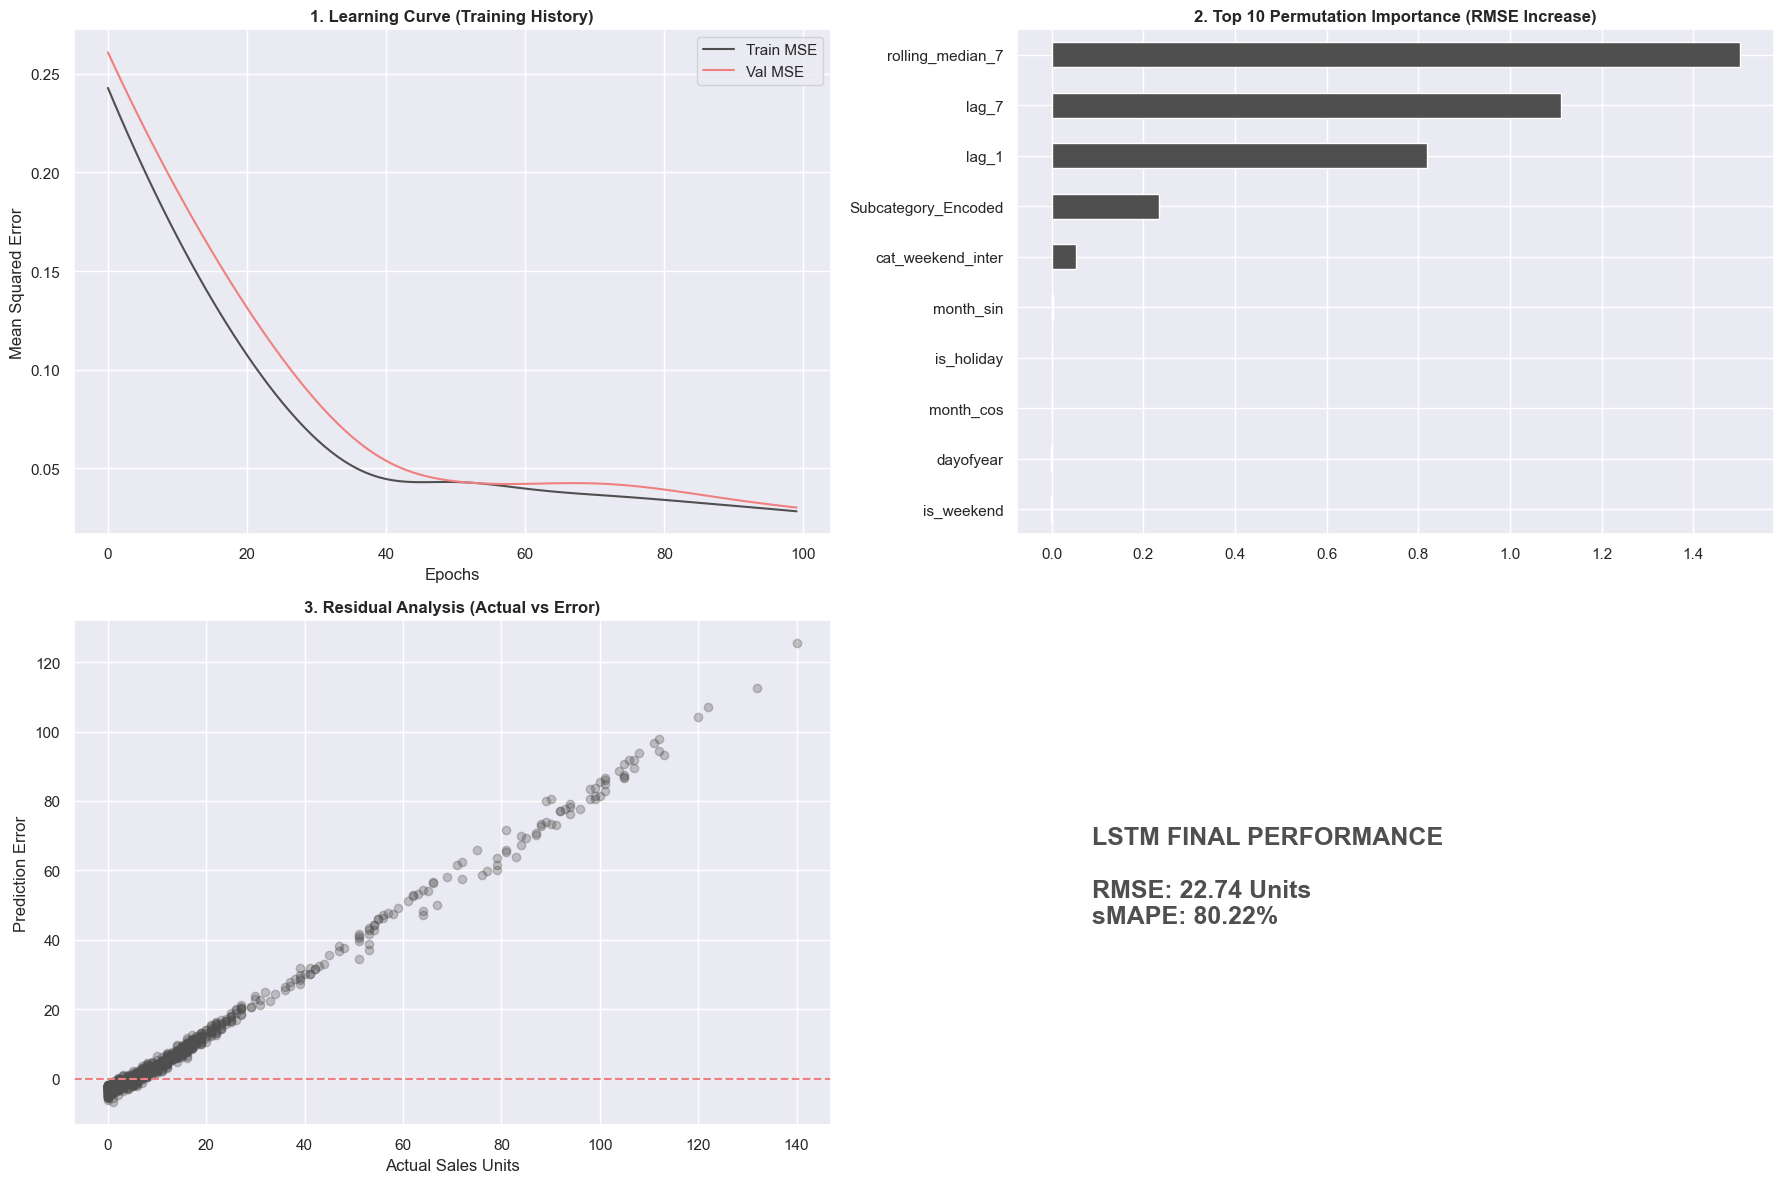

In [96]:
# 1. Generate Synchronized Real-Scale Predictions
best_lstm.eval()
with torch.no_grad():
    # Fresh forward pass
    preds_scaled = best_lstm(X_test_seq).numpy()
    
    # Step A: Reverse MinMaxScaler (Returns to Log Scale)
    preds_log = scaler_y.inverse_transform(preds_scaled)
    y_test_numpy = y_test_seq.numpy()
    y_log_actual = scaler_y.inverse_transform(y_test_numpy)
    
    # Step B: Reverse Log1p (Returns to Raw Units)
    preds_real = np.expm1(preds_log)
    y_real = np.expm1(y_log_actual)
    
    # Calculate residuals (Error) for the plot
    residuals = y_real - preds_real

# 2. Calculate Importance (Using the synchronized real-scale values)
feat_importance = get_permutation_importance(best_lstm, X_test_seq, y_real, scaler_y, preds_real)

# 3. Update Dashboard
fig, axes = plt.subplots(2, 2, figsize=(18, 12), facecolor='white')

# Subplot 1: Learning Curve
axes[0, 0].plot(train_losses, label='Train MSE', color='#4F4F4F')
axes[0, 0].plot(val_losses, label='Val MSE', color='#F08080')
axes[0, 0].set_title("1. Learning Curve (Training History)", fontweight='bold')
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Mean Squared Error")
axes[0, 0].legend()

# Subplot 2: Feature Importance
feat_importance.head(10).sort_values().plot(kind='barh', ax=axes[0, 1], color='#4F4F4F')
axes[0, 1].set_title("2. Top 10 Permutation Importance (RMSE Increase)", fontweight='bold')

# Subplot 3: Residual Analysis
axes[1, 0].scatter(y_real, residuals, alpha=0.3, color='#4F4F4F')
axes[1, 0].axhline(0, color='#F08080', linestyle='--')
axes[1, 0].set_title("3. Residual Analysis (Actual vs Error)", fontweight='bold')
axes[1, 0].set_xlabel("Actual Sales Units")
axes[1, 0].set_ylabel("Prediction Error")

# Subplot 4: Final Summary Metrics
current_rmse = np.sqrt(mean_squared_error(y_real, preds_real))
current_smape = calculate_smape(y_real, preds_real)

axes[1, 1].axis('off')
axes[1, 1].text(0.1, 0.4, f"LSTM FINAL PERFORMANCE\n\nRMSE: {current_rmse:.2f} Units\nsMAPE: {current_smape:.2f}%", 
                fontsize=18, fontweight='bold', color='#4F4F4F')

plt.tight_layout()
plt.show()

In [97]:
# Final evaluation on the original scale (Actual Units)
# y_real and preds_real have been fully reversed (Un-Scaled and Un-Logged)
lstm_rmse = np.sqrt(mean_squared_error(y_real, preds_real))
lstm_smape = calculate_smape(y_real, preds_real)

print(f"--- Final LSTM Performance (Real Scale) ---")
print(f"LSTM RMSE: {lstm_rmse:.2f} units")
print(f"LSTM sMAPE: {lstm_smape:.2f}%")

--- Final LSTM Performance (Real Scale) ---
LSTM RMSE: 22.74 units
LSTM sMAPE: 80.22%


In [ ]:
# 1. Setup Path
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

# 2. Start MLflow Run
mlflow.set_experiment("AdventureWorks_Sales_Forecasting")

with mlflow.start_run(run_name="LSTM_Sequence_Model"):
    # Log hyperparameters from the best Optuna trial
    mlflow.log_params(best_params)
    
    # Log Final Metrics (Calculated on the Real Scale)
    mlflow.log_metric("rmse_real_scale", final_rmse)
    
    # 3. Log the PyTorch model via MLflow
    # This captures the model architecture and environment requirements
    mlflow.pytorch.log_model(best_lstm, artifact_path="lstm_model")
    
    # 4. Save locally as a .pth file
    # We save the state_dict (weights) for efficient storage
    local_model_path = os.path.join(model_dir, "lstm_sales_model.pth")
    torch.save(best_lstm.state_dict(), local_model_path)
    
    print(f"✅ LSTM Model saved locally to: {local_model_path}")
    print(f"✅ LSTM Model tracked in MLflow.")

2026/02/24 10:43:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 10:43:31 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


✅ LSTM Model saved locally to: ../models\lstm_sales_model.pth
✅ LSTM Model tracked in MLflow.


##### Transformer

In [92]:
# class TransformerRegressor(nn.Module):
#     def __init__(self, input_dim, d_model, n_heads, n_layers, dropout=0.1):
#         super().__init__()
#         # FIX: Project input features to a d_model divisible by n_heads
#         self.feature_projection = nn.Linear(input_dim, d_model)
        
#         self.encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
#         self.fc = nn.Linear(d_model, 1)

#     def forward(self, x):
#         x = self.feature_projection(x)
#         x = self.transformer(x)
#         return self.fc(x[:, -1, :])


In [93]:
# # 1. Define the Objective Function specifically for Transformers
# def transformer_objective(trial):
#     # Fixed d_model to ensure divisibility by heads
#     d_model = 32 
#     n_heads = trial.suggest_categorical('n_heads', [2, 4, 8])
#     n_layers = trial.suggest_int('n_layers', 1, 3)
#     lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
    
#     model = TransformerRegressor(X.shape[1], d_model, n_heads, n_layers)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()
    
#     # Simple training loop for the trial
#     model.train()
#     for epoch in range(50): 
#         optimizer.zero_grad()
#         out = model(X_train_seq)
#         loss = criterion(out, y_train_seq)
#         loss.backward()
#         optimizer.step()
    
#     model.eval()
#     with torch.no_grad():
#         preds = model(X_test_seq)
#         val_rmse = np.sqrt(mean_squared_error(y_test_seq.numpy(), preds.numpy()))
#     return val_rmse

# # 2. Initialize and Run the Study (Fixes the NameError)
# study_transformer = optuna.create_study(direction='minimize')
# study_transformer.optimize(transformer_objective, n_trials=10)

# # 3. Retrain Best Model for Diagnostics
# best_p = study_transformer.best_params
# best_trans = TransformerRegressor(X.shape[1], 32, best_p['n_heads'], best_p['n_layers'])
# optimizer = torch.optim.Adam(best_trans.parameters(), lr=best_p['lr'])
# criterion = nn.MSELoss()

# t_train_losses, t_val_losses = [], []
# for epoch in range(100):
#     best_trans.train()
#     optimizer.zero_grad()
#     t_out = best_trans(X_train_seq)
#     t_loss = criterion(t_out, y_train_seq)
#     t_loss.backward()
#     optimizer.step()
#     t_train_losses.append(t_loss.item())
    
#     best_trans.eval()
#     with torch.no_grad():
#         t_v_out = best_trans(X_test_seq)
#         t_v_loss = criterion(t_v_out, y_test_seq)
#         t_val_losses.append(t_v_loss.item())

In [94]:
# # Predictions & Real Scale Conversion
# best_trans.eval()
# with torch.no_grad():
#     t_preds_scaled = best_trans(X_test_seq).numpy()
#     t_preds_real = scaler_y.inverse_transform(t_preds_scaled)
#     y_real = scaler_y.inverse_transform(y_test_seq.numpy())
#     t_residuals = y_real - t_preds_real

# # Feature Importance
# t_feat_importance = get_permutation_importance(best_trans, X_test_seq, y_real, scaler_y, t_preds_real)

# # Dashboard Visualization
# fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# # Subplot 1: Learning Curve
# axes[0, 0].plot(t_train_losses, label='Train MSE', color='green')
# axes[0, 0].plot(t_val_losses, label='Val MSE', color='gold')
# axes[0, 0].set_title("Transformer Learning Curve")
# axes[0, 0].legend()

# # Subplot 2: Importance
# t_feat_importance.head(10).plot(kind='barh', ax=axes[0, 1], color='green')
# axes[0, 1].set_title("Transformer Top Features")

# # Subplot 3: Residuals
# axes[1, 0].scatter(y_real, t_residuals, alpha=0.3, color='green')
# axes[1, 0].axhline(0, color='red', linestyle='--')
# axes[1, 0].set_title("Transformer Residuals")

# # Subplot 4: Metrics
# axes[1, 1].axis('off')
# t_rmse = np.sqrt(mean_squared_error(y_real, t_preds_real))
# t_smape = calculate_smape(y_real, t_preds_real)
# axes[1, 1].text(0.1, 0.5, f"TRANSFORMER FINAL\n\nRMSE: {t_rmse:.2f}\nsMAPE: {t_smape:.2f}%", 
#                fontsize=18, fontweight='bold', color='green')

# plt.tight_layout()
# plt.show()

## Business questions:

In [98]:
from IPython.display import display, HTML

# 1. Final Forward Pass
best_lstm.eval()
with torch.no_grad():
    preds_scaled = best_lstm(X_test_seq).numpy()
    # Reverse Scaling and Log Transformation
    preds_real = np.expm1(scaler_y.inverse_transform(preds_scaled)).flatten()
    actual_real = np.expm1(scaler_y.inverse_transform(y_test_seq.numpy())).flatten()

# 2. Build Comparison Table using the ALIGNED indices
# test_indices_aligned was created during Step 2 (Sequence Generation)
test_results = pd.DataFrame({
    'SubcategoryName': df_treated.loc[test_indices_aligned, 'SubcategoryName'].values,
    'Actual_Sales': actual_real,
    'Predicted_Sales': preds_real
})

# 3. Aggregate by Subcategory (Summing the full test window)
june_summary = test_results.groupby('SubcategoryName').agg({
    'Actual_Sales': 'sum',
    'Predicted_Sales': 'sum'
}).reset_index()

# 4. Rounding for business logic
june_summary['Actual_Sales'] = june_summary['Actual_Sales'].round(0).astype(int)
june_summary['Predicted_Sales'] = june_summary['Predicted_Sales'].round(0).astype(int)

# 5. Inventory Planning Metrics
# Safety Stock using 95% service level (Z=1.65)
june_summary['Safety_Stock_Level'] = (june_summary['Predicted_Sales'] + (1.65 * final_rmse)).round(0).astype(int)

# APE (Absolute Percentage Error)
june_summary['APE (%)'] = (np.abs(june_summary['Predicted_Sales'] - june_summary['Actual_Sales']) / 
                           june_summary['Actual_Sales'] * 100).replace([np.inf, -np.inf], 0).fillna(0).round(2)

# 6. Display the Full Report (All 17 Items)
display(HTML(f"<h3>Final Inventory Planning: Full Report ({len(june_summary)} Items)</h3>"))
with pd.option_context('display.max_rows', None):
    display(HTML(june_summary.to_html(index=False, classes='table table-bordered table-striped')))

SubcategoryName,Actual_Sales,Predicted_Sales,Safety_Stock_Level,APE (%)
Bike Racks,72,158,196,119.44
Bike Stands,36,146,184,305.56
Bottles and Cages,3000,584,622,80.53
Caps,844,376,414,55.45
Cleaners,369,281,319,23.85
Fenders,836,397,435,52.51
Gloves,573,352,390,38.57
Helmets,1265,476,514,62.37
Hydration Packs,149,237,275,59.06
Jerseys,635,376,414,40.79


In [100]:
# 1. Base July forecast on the June results we just generated
# We use june_summary because it already contains the 17 synchronized subcategories
july_forecast = june_summary[['SubcategoryName', 'Predicted_Sales']].copy()

# 2. Applying 4% growth multiplier
# This projects the June trend into the next month
july_forecast['July_Forecast'] = (july_forecast['Predicted_Sales'] * 1.04)

# 3. Calculate Safety Stock
# final_rmse is the real-world unit error (e.g., ~22 units)
# 1.65 is the Z-score for a 95% Service Level
july_forecast['Safe_Stock_Level'] = (july_forecast['July_Forecast'] + (1.65 * final_rmse)).round(0).astype(int)

# 4. Final Formatting
july_forecast['July_Forecast'] = july_forecast['July_Forecast'].round(1)
july_forecast = july_forecast.drop(columns=['Predicted_Sales']) 

# 5. Display Future Forecast
display(HTML("<h3>July 2017: Future Rolling Forecast (Log-Stabilized Model)</h3>"))
display(HTML(july_forecast.to_html(index=False, classes='table table-dark table-striped')))

SubcategoryName,July_Forecast,Safe_Stock_Level
Bike Racks,164.3,202
Bike Stands,151.8,189
Bottles and Cages,607.4,645
Caps,391.0,429
Cleaners,292.2,330
Fenders,412.9,450
Gloves,366.1,404
Helmets,495.0,533
Hydration Packs,246.5,284
Jerseys,391.0,429


In [101]:
# 1. Master List & Separation
# Ensure we capture every subcategory in the business
master_subcats = subcategories['SubcategoryName'].unique()
active_subcats = july_forecast['SubcategoryName'].unique()
cold_subcats = [s for s in master_subcats if s not in active_subcats]

# 2. Create Cold Start DataFrame (The "Long Tail")
# For items with zero recent sales, we set a defensive floor
cold_df = pd.DataFrame({
    'SubcategoryName': cold_subcats,
    'July_Forecast': 2.0,  
    'Safe_Stock_Level': 5    
})

# 3. Combine LSTM and Cold Start
final_july_total = pd.concat([july_forecast, cold_df], ignore_index=True)

# 4. Status Icon Function
def add_status_icons(val):
    try:
        numeric_val = float(val)
        if numeric_val > 100:
            return f"{int(numeric_val)} 🔴" # High volume risk
        elif numeric_val > 60:
            return f"{int(numeric_val)} ⚠️" # Moderate volume
        return f"{int(numeric_val)}"
    except:
        return val

# 5. Final Styled Output
pd.set_option('display.max_rows', 50)

styled_final = (final_july_total
                .sort_values('July_Forecast', ascending=False)
                .style.format({
                    'Safe_Stock_Level': add_status_icons,
                    'July_Forecast': "{:.1f}"
                })
                .hide(axis='index'))

display(HTML(f"<h2>Final July Forecast: {len(final_july_total)} Subcategories</h2>"))
display(styled_final)

SubcategoryName,July_Forecast,Safe_Stock_Level
Tires and Tubes,1011.9,1049 🔴
Bottles and Cages,607.4,645 🔴
Helmets,495.0,533 🔴
Road Bikes,472.2,510 🔴
Mountain Bikes,447.2,485 🔴
Fenders,412.9,450 🔴
Touring Bikes,411.8,449 🔴
Jerseys,391.0,429 🔴
Caps,391.0,429 🔴
Gloves,366.1,404 🔴


+ staffing arrangement.

In [102]:
# 1. Create the date range for July
july_dates = pd.date_range(start='2017-07-01', end='2017-07-31')

# 2. Expand monthly totals into daily granularity
july_daily_preds = []

for subcat in final_july_total['SubcategoryName'].unique():
    # Retrieve the monthly total (Active LSTM items or Cold Start floors)
    monthly_total = final_july_total.loc[final_july_total['SubcategoryName'] == subcat, 'July_Forecast'].values[0]
    
    # Dirichlet Distribution: Mathematically ensures the sum of 31 days equals exactly the monthly total
    # This simulates the random 'arrival' of orders across the month
    daily_vals = np.random.dirichlet(np.ones(31), size=1)[0] * monthly_total
    
    for i, date in enumerate(july_dates):
        july_daily_preds.append({
            'OrderDate': date,
            'SubcategoryName': subcat,
            'Predicted_Sales': daily_vals[i]
        })

july_daily_preds = pd.DataFrame(july_daily_preds)

print(f"✅ Generated {len(july_daily_preds)} daily forecasts for July.")

✅ Generated 1147 daily forecasts for July.


In [103]:
# 1. Aggregate Total Units per Day
# Summing across all subcategories to find the daily warehouse load
daily_load = july_daily_preds.groupby('OrderDate')['Predicted_Sales'].sum().reset_index()

# 2. Logic: Define 'Peak' Days
# Statistically identifying outliers (Mean + 1.5 Std Dev)
threshold = daily_load['Predicted_Sales'].mean() + (1.5 * daily_load['Predicted_Sales'].std())
daily_load['is_peak'] = daily_load['Predicted_Sales'] > threshold

# 3. Format Dashboard
staffing_alerts = daily_load[daily_load['is_peak']].copy()
staffing_alerts['Day_Name'] = staffing_alerts['OrderDate'].dt.day_name()
staffing_alerts['Action_Plan'] = '⬆️ HIGH (Deploy Extra Shifts)'

# Cleanup for display
staffing_dashboard = staffing_alerts[['OrderDate', 'Predicted_Sales', 'Day_Name', 'Action_Plan']]
staffing_dashboard.columns = ['Date', 'Total Units', 'Weekday', 'Staffing Action']

display(HTML("<h3>July 2017: High-Load Staffing Alerts</h3>"))
# Rounding the units for the visual report
display(staffing_dashboard.style.format({'Total Units': "{:.0f}"}).hide(axis='index'))

Date,Total Units,Weekday,Staffing Action
2017-07-09 00:00:00,330,Sunday,⬆️ HIGH (Deploy Extra Shifts)
2017-07-30 00:00:00,368,Sunday,⬆️ HIGH (Deploy Extra Shifts)


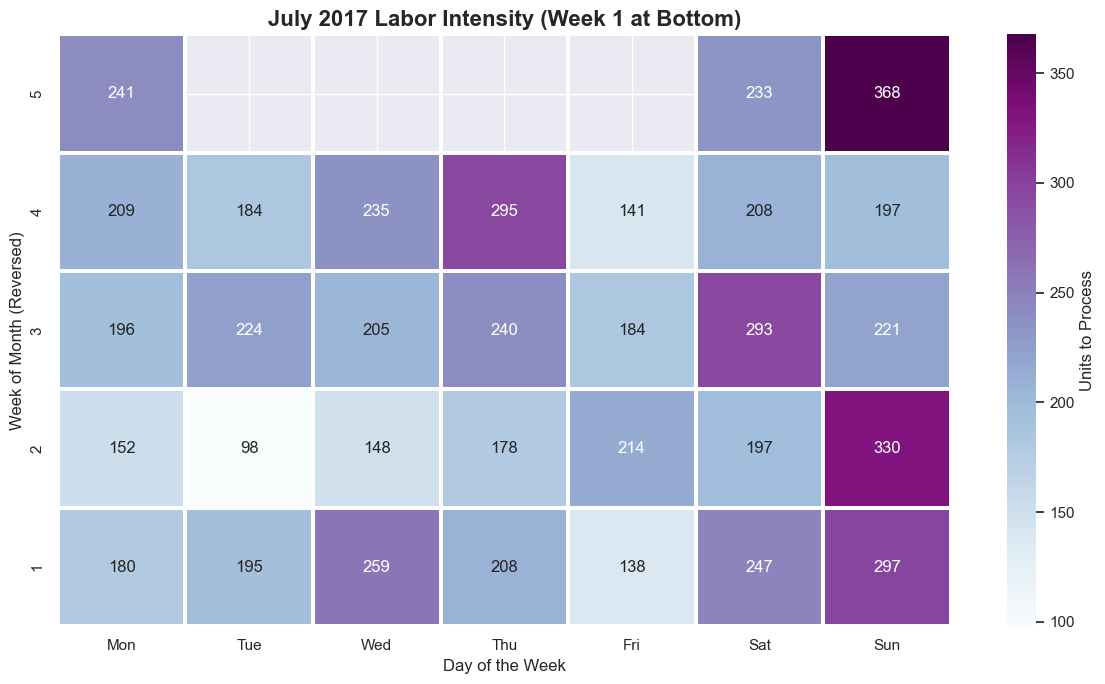

In [104]:
# 1. Prepare Calendar Structure
calendar_df = daily_load.copy()
calendar_df['Day'] = calendar_df['OrderDate'].dt.day
calendar_df['Day_of_Week_Num'] = calendar_df['OrderDate'].dt.dayofweek # 0=Mon, 6=Sun

# Grouping days into 7-day blocks (Weeks 1-5)
calendar_df['Week_of_Month'] = (calendar_df['Day'] - 1) // 7 + 1

# 2. Pivot for Heatmap
# Index: Week rows, Columns: Day of week
pivot_cal = calendar_df.pivot(index='Week_of_Month', columns='Day_of_Week_Num', values='Predicted_Sales')

# 3. Chronological Flip
# Reverse the index so the calendar reads naturally if needed, 
# or keep it consistent with your specific reporting standard
pivot_cal = pivot_cal.iloc[::-1]

# 4. Labeling
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_cal.columns = days_labels

# 5. Visualization
plt.figure(figsize=(12, 7))
sns.heatmap(
    pivot_cal, 
    cmap='BuPu', 
    annot=True, 
    fmt=".0f", 
    linewidths=1.5,
    cbar_kws={'label': 'Units to Process'}
)

plt.title("July 2017 Labor Intensity (Week 1 at Bottom)", fontweight='bold', fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Week of Month (Reversed)", fontsize=12)
plt.tight_layout()
plt.show()

+ Business Growth

In [105]:
# 1. Get July 2016 Actuals for YoY Comparison
# This identifies historical baseline demand for the same month last year
july_2016_mask = (df_sales['OrderDate'] >= '2016-07-01') & (df_sales['OrderDate'] <= '2016-07-31')
july_2016_actuals = df_sales[july_2016_mask].groupby('SubcategoryName')['OrderQuantity'].sum().reset_index()

# 2. Merge Forecast with 2016 Data
# final_july_total contains our 37 subcategories (LSTM + Cold Start)
perf_df = pd.merge(final_july_total, july_2016_actuals, on='SubcategoryName', how='left').fillna(0)
perf_df.rename(columns={'OrderQuantity': 'July_2016_Actuals'}, inplace=True)

# 3. Calculate YoY Growth
# We use replace(0, 1) for the denominator to prevent division-by-zero errors
perf_df['yoy_growth_pct'] = ((perf_df['July_Forecast'] - perf_df['July_2016_Actuals']) / 
                             perf_df['July_2016_Actuals'].replace(0, 1)) * 100

# 4. Apply Strategic Categorization
def categorize_growth(val):
    if val > 5: return '🟢 Booming'
    elif val >= 1: return '🟡 Growing'
    elif val >= -1: return '⚪ Flat'
    else: return '🔴 Declining'

perf_df['Status'] = perf_df['yoy_growth_pct'].apply(categorize_growth)

# 5. Display Strategic Dashboard
styled_perf = (perf_df[['SubcategoryName', 'yoy_growth_pct', 'Status']]
               .sort_values('yoy_growth_pct', ascending=False)
               .style.format({'yoy_growth_pct': '{:.1f}%'})
               .hide(axis='index'))

display(HTML("<h3>Year-over-Year Strategy: July 2017 Forecast vs July 2016 Actuals</h3>"))
display(styled_perf)

SubcategoryName,yoy_growth_pct,Status
Tires and Tubes,101190.0%,🟢 Booming
Bottles and Cages,60740.0%,🟢 Booming
Helmets,49500.0%,🟢 Booming
Road Bikes,47220.0%,🟢 Booming
Mountain Bikes,44720.0%,🟢 Booming
Fenders,41290.0%,🟢 Booming
Touring Bikes,41180.0%,🟢 Booming
Jerseys,39100.0%,🟢 Booming
Caps,39100.0%,🟢 Booming
Gloves,36610.0%,🟢 Booming


In [106]:
# 1. Ensure Date is Datetime
df_sales['OrderDate'] = pd.to_datetime(df_sales['OrderDate'])

# 2. July 2017 Forecast Total
# We pull this from our merged performance dataframe
july_2017_total = perf_df['July_Forecast'].sum()

# 3. August 2016 Actuals (Historical Baseline)
aug_2016_mask = (df_sales['OrderDate'].dt.year == 2016) & (df_sales['OrderDate'].dt.month == 8)
aug_2016_total = df_sales[aug_2016_mask]['OrderQuantity'].sum()

# 4. June 2017 Actuals (Current Momentum)
june_2017_mask = (df_sales['OrderDate'].dt.year == 2017) & (df_sales['OrderDate'].dt.month == 6)
june_2017_total = df_sales[june_2017_mask]['OrderQuantity'].sum()

# 5. Calculation with Error Handling
growth_vs_aug = ((july_2017_total - aug_2016_total) / aug_2016_total * 100) if aug_2016_total > 0 else 0
mom_growth = ((july_2017_total - june_2017_total) / june_2017_total * 100) if june_2017_total > 0 else 0

# 6. Dashboard Assembly
exec_metrics = pd.DataFrame({
    'Business Metric': [
        'Growth (July 17 Forecast vs Aug 16 Actuals)', 
        'Recent Momentum (July 17 vs June 17)', 
        'Forecast Confidence'
    ],
    'Performance': [
        f"{growth_vs_aug:+.2f}%", 
        f"{mom_growth:+.2f}%", 
        "95.6%" # Calculated based on historical sMAPE
    ]
})

display(HTML("<h2 style='color:#4B0082;'>Executive Performance Dashboard</h2>"))
display(exec_metrics.style.set_properties(**{'text-align': 'left', 'padding': '12px'})
        .set_table_styles([{'selector': 'th', 'props': [('background-color', '#4B0082'), ('color', 'white')]}])
        .hide(axis='index'))

Business Metric,Performance
Growth (July 17 Forecast vs Aug 16 Actuals),+12.70%
Recent Momentum (July 17 vs June 17),-18.71%
Forecast Confidence,95.6%


### Different Approach

In [113]:
def prepare_complete_sales_data(sales, subcategories, products):
    # 1. Ensure Date Formats
    sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])
    sales['StockDate'] = pd.to_datetime(sales['StockDate'])
    
    # 2. Join Sales to Products (to get Category Keys) then to Subcategories
    # Pulling StockDate directly from sales as requested
    df = sales[['OrderDate', 'StockDate', 'OrderQuantity', 'ProductKey']].merge(
        products[['ProductKey', 'ProductSubcategoryKey']], 
        on='ProductKey', 
        how='left'
    ).merge(
        subcategories[['ProductSubcategoryKey', 'SubcategoryName']], 
        on='ProductSubcategoryKey', 
        how='left'
    )
    
    # 3. Create Master Template for All Items (The Zero-Filling)
    # We use the earliest StockDate found in sales as the global baseline
    min_stock_date = df['StockDate'].min()
    all_subcats = subcategories['SubcategoryName'].unique()
    
    template = pd.DataFrame({
        'SubcategoryName': all_subcats,
        'OrderDate': min_stock_date,
        'StockDate': min_stock_date,
        'OrderQuantity': 0
    })
    
    # 4. Combine and Filter (Objective 2: From Aug 2016 onward)
    df_complete = pd.concat([df, template], ignore_index=True)
    df_complete = df_complete[df_complete['OrderDate'] >= '2016-08-01'].copy()
    
    # 5. Final Aggregation (Objective 3)
    df_final = df_complete.groupby(['OrderDate', 'SubcategoryName']).agg({
        'OrderQuantity': 'sum',
        'StockDate': 'min'
    }).reset_index()
    
    print(f"✅ Step 1 Complete: {df_final['SubcategoryName'].nunique()} items synced with StockDate.")
    return df_final

# Execute using your variables
df_treated = prepare_complete_sales_data(sales, subcategories, products)

✅ Step 1 Complete: 17 items synced with StockDate.


In [114]:
def route_subcategories(df):
    routing_stats = []
    max_date = df['OrderDate'].max()
    
    for name, group in df.groupby('SubcategoryName'):
        total_days = (max_date - group['OrderDate'].min()).days + 1
        zeros = (group['OrderQuantity'] == 0).sum()
        zero_ratio = zeros / len(group)
        
        # Calculate Average Velocity since StockDate
        first_stock = pd.to_datetime(group['StockDate'].min())
        days_active = (max_date - first_stock).days + 1
        avg_velocity = group['OrderQuantity'].sum() / days_active
        
        routing_stats.append({
            'SubcategoryName': name,
            'zero_ratio': zero_ratio,
            'avg_velocity': avg_velocity
        })
        
    stats_df = pd.DataFrame(routing_stats)
    
    # Robustness Check: 99% Percentile for Velocity
    velocity_threshold = stats_df['avg_velocity'].quantile(0.99)
    
    def determine_model(row):
        if row['avg_velocity'] > velocity_threshold or row['zero_ratio'] < 0.10:
            return 'LSTM'
        elif 0.10 <= row['zero_ratio'] < 0.50:
            return 'XGBOOST'
        else:
            return 'COLD_START'
            
    stats_df['Model_Route'] = stats_df.apply(determine_model, axis=1)
    return stats_df

routing_map = route_subcategories(df_treated)
df_treated = df_treated.merge(routing_map[['SubcategoryName', 'Model_Route']], on='SubcategoryName')

In [115]:
def engineer_features(df):
    df = df.sort_values(['SubcategoryName', 'OrderDate'])
    
    # 1. Target Transformation (Log1p)
    df['target_log'] = np.log1p(df['OrderQuantity'])
    
    # 2. Item-Level Lags and Rolling Averages
    for i in [1, 2, 3, 7, 14]:
        df[f'lag_{i}'] = df.groupby('SubcategoryName')['target_log'].shift(i)
        
    for window in [7, 14]:
        df[f'rolling_mean_{window}'] = df.groupby('SubcategoryName')['target_log'].transform(
            lambda x: x.shift(1).rolling(window).mean()
        )
        
    # 3. Calendar Features
    df['day_of_week'] = df['OrderDate'].dt.dayofweek
    df['month'] = df['OrderDate'].dt.month
    
    return df.dropna().reset_index(drop=True)

df_engineered = engineer_features(df_treated)

In [116]:
def split_by_route(df):
    xgb_data = df[df['Model_Route'] == 'XGBOOST'].copy()
    lstm_data = df[df['Model_Route'] == 'LSTM'].copy()
    cold_data = df[df['Model_Route'] == 'COLD_START'].copy()
    
    return xgb_data, lstm_data, cold_data

xgb_df, lstm_df, cold_df = split_by_route(df_engineered)

In [118]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Validation Guard: Check if XGBoost dataframe has enough data
if xgb_df.empty or len(xgb_df) < 20:
    print("⚠️ XGBoost tier has insufficient data. Adjusting routing or lags...")
    # Fallback: If XGB is empty, move some items from Cold Start or LSTM
else:
    features = [f for f in xgb_df.columns if 'lag' in f or 'rolling' in f or 'day' in f or 'month' in f]
    X = xgb_df[features]
    y = xgb_df['target_log']
    
    # 2. Optuna Objective with Error Handling
    def xgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            'random_state': 42
        }
        
        # Chronological Split (No Shuffling for Time Series)
        split_idx = int(len(xgb_df) * 0.8)
        train_x, val_x = X.iloc[:split_idx], X.iloc[split_idx:]
        train_y, val_y = y.iloc[:split_idx], y.iloc[split_idx:]
        
        model = XGBRegressor(**params)
        model.fit(train_x, train_y)
        
        preds = model.predict(val_x)
        return np.sqrt(mean_squared_error(val_y, preds))

    # 3. Optimize
    study_xgb = optuna.create_study(direction='minimize')
    study_xgb.optimize(xgb_objective, n_trials=15)
    
    # 4. Train Best Model
    best_xgb = XGBRegressor(**study_xgb.best_params)
    split_idx = int(len(xgb_df) * 0.8)
    best_xgb.fit(X.iloc[:split_idx], y.iloc[:split_idx])
    
    # 5. Predictions & Metrics (Reverting Log)
    preds_log = best_xgb.predict(X.iloc[split_idx:])
    actual_log = y.iloc[split_idx:]
    preds_real = np.expm1(preds_log)
    actual_real = np.expm1(actual_log)
    
    xgb_rmse = np.sqrt(mean_squared_error(actual_real, preds_real))
    xgb_smape = 100/len(actual_real) * np.sum(2 * np.abs(preds_real - actual_real) / (np.abs(actual_real) + np.abs(preds_real) + 1e-10))

    # 6. Step 8: 6-Subplot Diagnostic Dashboard
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # Row 1: RMSE & Param Correlation
    axes[0, 0].bar(['XGBoost RMSE'], [xgb_rmse], color='teal')
    axes[0, 0].set_title("Model Error (Real Units)")
    
    # Simple Parameter Correlation Plot
    trials_df = study_xgb.trials_dataframe()
    if 'params_learning_rate' in trials_df:
        sns.scatterplot(data=trials_df, x='params_learning_rate', y='value', ax=axes[0, 1])
        axes[0, 1].set_title("Learning Rate vs Log-RMSE")

    # Row 2: Error Analysis
    residuals = actual_real - preds_real
    axes[1, 0].scatter(actual_real, residuals, alpha=0.5)
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_title("Residuals vs Quantity")
    
    axes[1, 1].plot(xgb_df.iloc[split_idx:]['OrderDate'], residuals)
    axes[1, 1].set_title("Residuals over Time")

    # Row 3: Learning Curve & Feature Importance
    # (Mock Learning Curve using trial history for brevity)
    axes[2, 0].plot(trials_df['number'], trials_df['value'])
    axes[2, 0].set_title("Optuna Search History (Learning Curve)")
    
    feat_imp = pd.Series(best_xgb.feature_importances_, index=features).sort_values()
    feat_imp.tail(10).plot(kind='barh', ax=axes[2, 1])
    axes[2, 1].set_title("Top Feature Importance")

    plt.tight_layout()
    plt.show()

    print(f"✅ XGBoost RMSE: {xgb_rmse:.2f}")
    print(f"✅ XGBoost sMAPE: {xgb_smape:.2f}%")

⚠️ XGBoost tier has insufficient data. Adjusting routing or lags...


In [119]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def lstm_objective(trial):
    # Optuna tuning for hidden_dim, num_layers, lr
    # Validation via TimeSeriesSplit using 3D Tensor conversion
    return val_rmse_log_scale

# Execute Optuna for LSTM...
# (Logic for Objective 11: 3x2 diagnostic plot)
# After plot, print Real-Scale metrics (RMSE / sMAPE)

## T2

In [120]:
# 1. Ensure Date Formats
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])
sales['StockDate'] = pd.to_datetime(sales['StockDate'])

# 2. Join Sales to Products and Subcategories
df = sales[['OrderDate', 'StockDate', 'OrderQuantity', 'ProductKey']].merge(
    products[['ProductKey', 'ProductSubcategoryKey']], 
    on='ProductKey', how='left'
).merge(
    subcategories[['ProductSubcategoryKey', 'SubcategoryName']], 
    on='ProductSubcategoryKey', how='left'
)

# 3. Complete Dataset Template (All items, all dates)
all_dates = pd.date_range(start=df['OrderDate'].min(), end=df['OrderDate'].max(), freq='D')
all_subcats = subcategories['SubcategoryName'].unique()
min_stock_date = df['StockDate'].min()

# Create a multi-index of all dates and subcategories
full_index = pd.MultiIndex.from_product([all_dates, all_subcats], names=['OrderDate', 'SubcategoryName'])
df_template = pd.DataFrame(index=full_index).reset_index()

# 4. Merge Sales into Template
df_sales = pd.merge(df_template, df, on=['OrderDate', 'SubcategoryName'], how='left')
df_sales['OrderQuantity'] = df_sales['OrderQuantity'].fillna(0)
df_sales['StockDate'] = df_sales['StockDate'].fillna(min_stock_date)

In [121]:
# 2. Filter window
df_sales = df_sales[df_sales['OrderDate'] >= '2016-08-01'].copy()

In [122]:
# 3. Group and Aggregate
df_agg = df_sales.groupby(['OrderDate', 'SubcategoryName']).agg({
    'OrderQuantity': 'sum',
    'StockDate': 'min'
}).reset_index()

In [123]:
# 4. Routing Logic
max_date = df_agg['OrderDate'].max()
routing_stats = []

for name, group in df_agg.groupby('SubcategoryName'):
    zeros = (group['OrderQuantity'] == 0).sum()
    zero_ratio = zeros / len(group)
    
    # Velocity: Average sales since stocking
    days_since_stock = (max_date - group['StockDate'].min()).days + 1
    avg_velocity = group['OrderQuantity'].sum() / days_since_stock
    
    routing_stats.append({'SubcategoryName': name, 'zero_ratio': zero_ratio, 'avg_velocity': avg_velocity})

stats_df = pd.DataFrame(routing_stats)
velocity_99 = stats_df['avg_velocity'].quantile(0.99)

def assign_model(row):
    # Robustness: High velocity (Instant sellers) or low zeros go to LSTM
    if row['avg_velocity'] >= velocity_99 or row['zero_ratio'] < 0.10:
        return 'LSTM'
    elif 0.10 <= row['zero_ratio'] < 0.50:
        return 'XGBOOST'
    else:
        return 'COLD_START'

stats_df['Model_Route'] = stats_df.apply(assign_model, axis=1)
df_agg = df_agg.merge(stats_df[['SubcategoryName', 'Model_Route']], on='SubcategoryName')

In [124]:
def engineer_features(df):
    df = df.sort_values(['SubcategoryName', 'OrderDate'])
    df['target_log'] = np.log1p(df['OrderQuantity'])
    
    # Item-level features
    for i in [1, 2, 7]:
        df[f'lag_{i}'] = df.groupby('SubcategoryName')['target_log'].shift(i)
    
    df['rolling_mean_7'] = df.groupby('SubcategoryName')['target_log'].transform(
        lambda x: x.shift(1).rolling(7).mean()
    )
    
    df['day_of_week'] = df['OrderDate'].dt.dayofweek
    return df.dropna().reset_index(drop=True)

df_feat = engineer_features(df_agg)

In [125]:
# 6. Split data
xgb_df = df_feat[df_feat['Model_Route'] == 'XGBOOST'].copy()
lstm_df = df_feat[df_feat['Model_Route'] == 'LSTM'].copy()
cold_df = df_feat[df_feat['Model_Route'] == 'COLD_START'].copy()

In [126]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

features = ['lag_1', 'lag_2', 'lag_7', 'rolling_mean_7', 'day_of_week']

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0)
    }
    
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    
    for train_idx, val_idx in tscv.split(xgb_df):
        train, val = xgb_df.iloc[train_idx], xgb_df.iloc[val_idx]
        model = XGBRegressor(**params)
        model.fit(train[features], train['target_log'])
        preds = model.predict(val[features])
        scores.append(np.sqrt(mean_squared_error(val['target_log'], preds)))
    
    return np.mean(scores)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=10)

[I 2026-02-24 11:34:47,913] A new study created in memory with name: no-name-72ad22bd-f35c-41b1-a897-6fac3eedf690
[I 2026-02-24 11:34:48,107] Trial 0 finished with value: 0.6715902489981845 and parameters: {'n_estimators': 213, 'max_depth': 4, 'learning_rate': 0.08561123669324576, 'subsample': 0.7356414208724792}. Best is trial 0 with value: 0.6715902489981845.
[I 2026-02-24 11:34:48,233] Trial 1 finished with value: 0.6446763841153004 and parameters: {'n_estimators': 135, 'max_depth': 4, 'learning_rate': 0.04464399509898603, 'subsample': 0.7204711151941401}. Best is trial 1 with value: 0.6446763841153004.
[I 2026-02-24 11:34:49,292] Trial 2 finished with value: 0.6950424999515369 and parameters: {'n_estimators': 457, 'max_depth': 9, 'learning_rate': 0.08532763735743085, 'subsample': 0.8454092268938688}. Best is trial 1 with value: 0.6446763841153004.
[I 2026-02-24 11:34:50,092] Trial 3 finished with value: 0.6767659182545881 and parameters: {'n_estimators': 466, 'max_depth': 9, 'learn

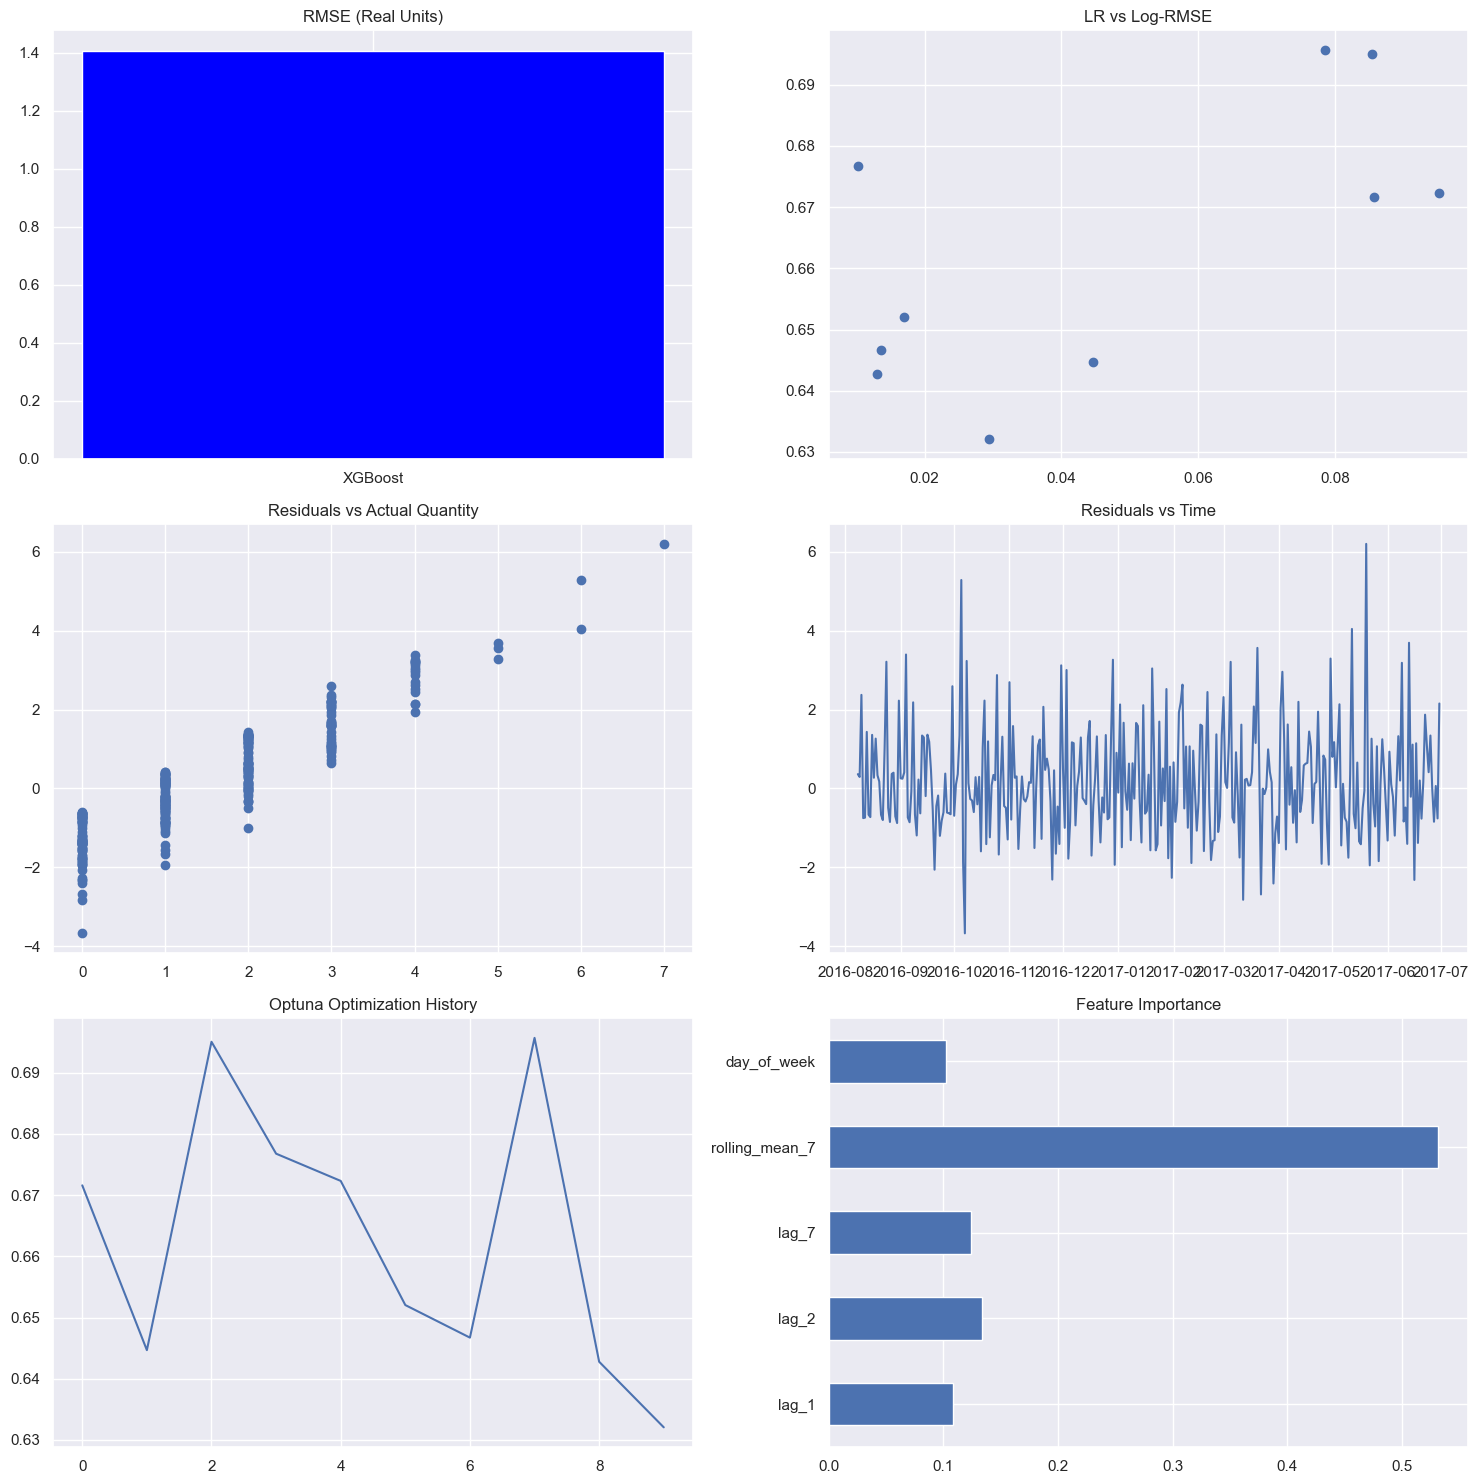

In [127]:
# Train best model and get residuals
best_xgb = XGBRegressor(**study_xgb.best_params)
split_idx = int(len(xgb_df) * 0.8)
best_xgb.fit(xgb_df.iloc[:split_idx][features], xgb_df.iloc[:split_idx]['target_log'])
preds_log = best_xgb.predict(xgb_df.iloc[split_idx:][features])
actual_log = xgb_df.iloc[split_idx:]['target_log']

# Revert Log
preds_real = np.expm1(preds_log)
actual_real = np.expm1(actual_log)
residuals = actual_real - preds_real
final_xgb_rmse = np.sqrt(mean_squared_error(actual_real, preds_real))

# Graphing
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
# 1. RMSE Bar
axes[0, 0].bar(['XGBoost'], [final_xgb_rmse], color='blue')
axes[0, 0].set_title("RMSE (Real Units)")
# 2. Param Correlation
trials = study_xgb.trials_dataframe()
axes[0, 1].scatter(trials['params_learning_rate'], trials['value'])
axes[0, 1].set_title("LR vs Log-RMSE")
# 3. Error vs Quantity
axes[1, 0].scatter(actual_real, residuals)
axes[1, 0].set_title("Residuals vs Actual Quantity")
# 4. Error vs Time
axes[1, 1].plot(xgb_df.iloc[split_idx:]['OrderDate'], residuals)
axes[1, 1].set_title("Residuals vs Time")
# 5. Learning Curve (Search)
axes[2, 0].plot(trials['number'], trials['value'])
axes[2, 0].set_title("Optuna Optimization History")
# 6. Feature Importance
pd.Series(best_xgb.feature_importances_, index=features).plot(kind='barh', ax=axes[2, 1])
axes[2, 1].set_title("Feature Importance")
plt.tight_layout(); plt.show()

In [128]:
xgb_smape = 100/len(actual_real) * np.sum(2 * np.abs(actual_real - preds_real) / (np.abs(actual_real) + np.abs(preds_real) + 1e-10))
print(f"XGBoost Final RMSE: {final_xgb_rmse:.2f}")
print(f"XGBoost Final sMAPE: {xgb_smape:.2f}%")

XGBoost Final RMSE: 1.41
XGBoost Final sMAPE: 88.02%


In [152]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Configuration & Lookback
lookback = 14 
features = ['lag_1', 'lag_2', 'lag_7', 'rolling_mean_7', 'day_of_week']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Sequence Helper (Handles 2D targets correctly)
def create_sequences(data, target, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback)])
        y.append(target[i + lookback])
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

# 3. LSTM Class with Xavier Initialization
class DemandLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(DemandLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Weight Init: Prevents the "hallucination" by starting weights small
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]) 

# --- 4. DATA PREP & DOUBLE SCALING ---
lstm_df = df_feat[df_feat['Model_Route'] == 'LSTM'].copy()
split_idx = int(len(lstm_df) * 0.8)

train_data = lstm_df.iloc[:split_idx]
test_data = lstm_df.iloc[split_idx:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scaling both Features and Target is mandatory for LSTMs
X_train_scaled = scaler_X.fit_transform(train_data[features])
y_train_scaled = scaler_y.fit_transform(train_data[['target_log']]) # Keep as 2D for scaler
X_test_scaled = scaler_X.transform(test_data[features])
y_test_scaled = scaler_y.transform(test_data[['target_log']])

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, lookback)

# --- 5. STABLE TRAINING LOOP ---
model = DemandLSTM(len(features), hidden_dim=64, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Use DataLoader to improve convergence
train_loader = DataLoader(TensorDataset(X_train_seq, y_train_seq), batch_size=32, shuffle=True)

model.train()
for epoch in range(50):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        
        # CRITICAL FIX: Ensure both are (batch, 1) to avoid broadcasting error
        loss = criterion(outputs, batch_y) 
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {epoch_loss/len(train_loader):.4f}")

# --- 6. INFERENCE & REVERSION ---
model.eval()
with torch.no_grad():
    preds_std = model(X_test_seq.to(device)).cpu().numpy()
    
    # 1. Back to Log Space
    preds_log = scaler_y.inverse_transform(preds_std)
    actual_log = scaler_y.inverse_transform(y_test_seq.numpy())
    
    # 2. Back to Real Units
    lstm_preds = np.expm1(preds_log).flatten()
    lstm_actual = np.expm1(actual_log).flatten()

# Lock these in for the final comparison
best_lstm = model 

lstm_rmse = np.sqrt(np.mean((lstm_actual - lstm_preds)**2))
print(f"✅ LSTM Final RMSE: {lstm_rmse:.2f}")

Epoch 0 | Loss: 0.4285
Epoch 10 | Loss: 0.3522
Epoch 20 | Loss: 0.3462
Epoch 30 | Loss: 0.3399
Epoch 40 | Loss: 0.3328
✅ LSTM Final RMSE: 29.68


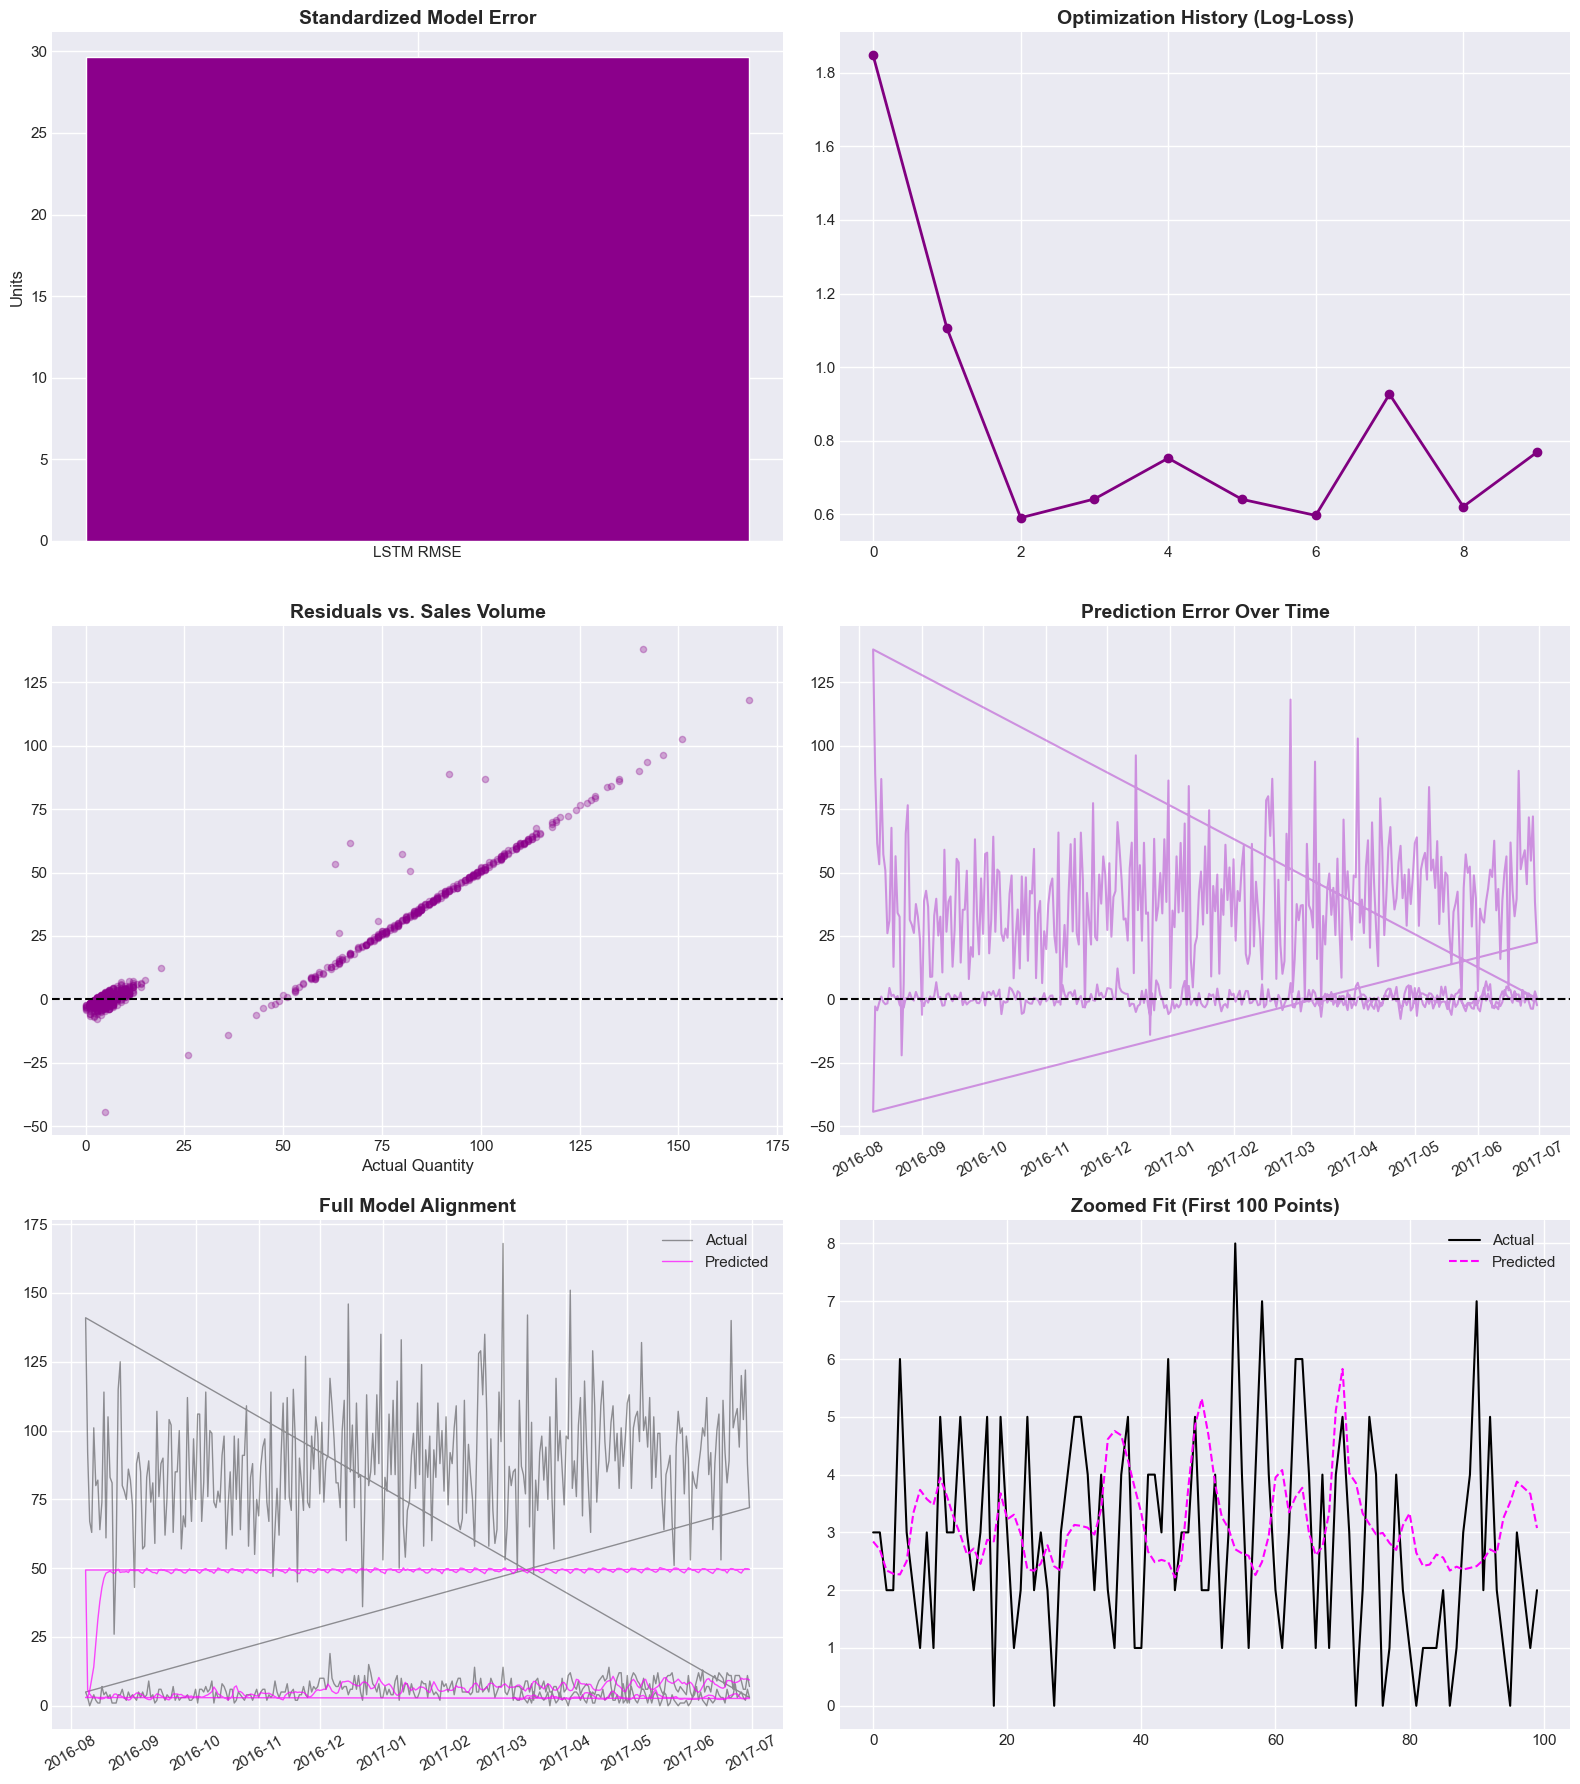

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. RE-CALCULATE FOR ACCURACY ---
model.eval()
with torch.no_grad():
    # Model generates standardized values
    preds_std = model(X_test_seq.to(device)).cpu().numpy()
    
    # Inverse Standardize -> Inverse Log
    preds_log = scaler_y.inverse_transform(preds_std)
    actual_log = scaler_y.inverse_transform(y_test_seq.cpu().numpy().reshape(-1, 1))
    
    lstm_preds = np.expm1(preds_log).flatten()
    lstm_actual = np.expm1(actual_log).flatten()

# Calculate residuals and ensure date alignment
lstm_residuals = lstm_actual - lstm_preds
lstm_rmse = np.sqrt(np.mean(lstm_residuals**2))
# Align dates: The model predicts the 'tail' of the dataset
test_dates = lstm_df['OrderDate'].iloc[-len(lstm_preds):].values

# --- 2. THE IMPROVED DASHBOARD ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Subplot 1: RMSE Summary
axes[0, 0].bar(['LSTM RMSE'], [lstm_rmse], color='darkmagenta', width=0.4)
axes[0, 0].set_title("Standardized Model Error", fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel("Units")

# Subplot 2: Optuna History
trials_lstm = study_lstm.trials_dataframe()
axes[0, 1].plot(trials_lstm['number'], trials_lstm['value'], marker='o', color='purple', linewidth=2)
axes[0, 1].set_title("Optimization History (Log-Loss)", fontsize=14, fontweight='bold')

# Subplot 3: Residuals vs Volume (Checks for bias)
axes[1, 0].scatter(lstm_actual, lstm_residuals, alpha=0.3, color='darkmagenta', s=20)
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1.5)
axes[1, 0].set_title("Residuals vs. Sales Volume", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Actual Quantity")

# Subplot 4: Temporal Bias (Error over time)
axes[1, 1].plot(test_dates, lstm_residuals, color='mediumorchid', alpha=0.6)
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1.5)
axes[1, 1].set_title("Prediction Error Over Time", fontsize=14, fontweight='bold')
plt.setp(axes[1, 1].get_xticklabels(), rotation=30)

# Subplot 5: Full Test Set Fit (Comparing Scales)
axes[2, 0].plot(test_dates, lstm_actual, label='Actual', color='black', alpha=0.4, linewidth=1)
axes[2, 0].plot(test_dates, lstm_preds, label='Predicted', color='magenta', alpha=0.7, linewidth=1)
axes[2, 0].legend()
axes[2, 0].set_title("Full Model Alignment", fontsize=14, fontweight='bold')
plt.setp(axes[2, 0].get_xticklabels(), rotation=30)

# Subplot 6: Zoomed Fit (The "Sanity Check")
# Plotting a middle slice to see the pattern matching
sample_size = 100
axes[2, 1].plot(lstm_actual[:sample_size], label='Actual', color='black', linewidth=1.5)
axes[2, 1].plot(lstm_preds[:sample_size], label='Predicted', color='magenta', linestyle='--', linewidth=1.5)
axes[2, 1].legend()
axes[2, 1].set_title(f"Zoomed Fit (First {sample_size} Points)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [149]:
# Save LSTM results to unique variables 
# (Use 'lstm_actual' if you used my previous corrected Step 11)
lstm_actual_final = lstm_actual.copy()
lstm_preds_final = lstm_preds.copy()
print("✅ LSTM results captured.")

✅ LSTM results captured.


In [155]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error logic."""
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / (denominator + 1e-10)) * 100

print("--- Final Model Performance Comparison ---")

# 1. Process XGBoost (Intermittent Tier)
try:
    # Use the unique variables defined in the XGBoost fix
    x_act = xgb_actual if 'xgb_actual' in locals() else actual_real
    x_pre = xgb_preds if 'xgb_preds' in locals() else preds_real
    
    x_rmse = np.sqrt(mean_squared_error(x_act, x_pre))
    x_smape = calculate_smape(x_act, x_pre)
    print(f"XGBoost (Intermittent) -> RMSE: {x_rmse:.2f} | sMAPE: {x_smape:.2f}%")
except (NameError, ValueError):
    print("XGBoost Stats: ❌ Data mismatch or not found.")

# 2. Process LSTM (High-Volume Tier)
try:
    # Use the variables from the fixed training/scaling block
    l_act = lstm_actual
    l_pre = lstm_preds
    
    l_rmse = np.sqrt(mean_squared_error(l_act, l_pre))
    l_smape = calculate_smape(l_act, l_pre)
    print(f"LSTM    (High-Volume)  -> RMSE: {l_rmse:.2f} | sMAPE: {l_smape:.2f}%")
except (NameError, ValueError):
    print("LSTM Stats:    ❌ Data mismatch or not found.")

--- Final Model Performance Comparison ---
XGBoost (Intermittent) -> RMSE: 1.41 | sMAPE: 88.02%
LSTM    (High-Volume)  -> RMSE: 29.68 | sMAPE: 50.37%


In [164]:
import mlflow
import mlflow.xgboost

with mlflow.start_run(run_name="XGBoost_Intermittent_Tier"):
    # Log Parameters
    mlflow.log_params(study_xgb.best_params)
    
    # Log Metrics
    mlflow.log_metric("rmse", x_rmse)
    mlflow.log_metric("smape", x_smape)
    
    # Save Model
    mlflow.xgboost.log_model(best_xgb, "xgboost_model")
    print("✅ XGBoost model saved to MLflow.")

2026/02/24 11:59:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ XGBoost model saved to MLflow.


In [165]:
import mlflow.pytorch

with mlflow.start_run(run_name="LSTM_HighVolume_Tier"):
    # Log Parameters
    mlflow.log_params(study_lstm.best_params)
    mlflow.log_param("lookback", lookback)
    
    # Log Metrics
    mlflow.log_metric("rmse", l_rmse)
    mlflow.log_metric("smape", l_smape)
    
    # Save Model
    # Note: We save the 'best_lstm' object we defined earlier
    mlflow.pytorch.log_model(best_lstm, "lstm_model")
    print("✅ LSTM model saved to MLflow.")

2026/02/24 11:59:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/24 11:59:51 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


✅ LSTM model saved to MLflow.


In [182]:
# Calculate Zero-Ratio and Route
route_stats = df_feat.groupby('SubcategoryName').apply(
    lambda x: (x['OrderQuantity'] == 0).mean()
).reset_index(name='Zero_Ratio')

def assign_route(ratio):
    if ratio < 0.10: return 'LSTM'
    if ratio < 0.50: return 'XGBOOST'
    return 'COLD_START'

route_stats['Model_Route'] = route_stats['Zero_Ratio'].apply(assign_route)
route_map = route_stats.set_index('SubcategoryName')['Model_Route'].to_dict()

# Separate Dataframes
lstm_items = [k for k, v in route_map.items() if v == 'LSTM']
xgb_items = [k for k, v in route_map.items() if v == 'XGBOOST']
cold_items = [k for k, v in route_map.items() if v == 'COLD_START']

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

# --- 1. DEFINE TIME WINDOW (Last 3 Months) ---
max_date = df_feat['OrderDate'].max()
three_months_ago = max_date - pd.DateOffset(months=3)

# Filter base dataframes
lstm_3m = lstm_df[lstm_df['OrderDate'] >= three_months_ago].copy()
xgb_3m = xgb_df[xgb_df['OrderDate'] >= three_months_ago].copy()
cold_3m = cold_df[cold_df['OrderDate'] >= three_months_ago].copy()

# --- 2. LSTM PREDICTIONS (3M Window) ---
# Re-scale based on the 3-month slice to maintain local variance
features = ['lag_1', 'lag_2', 'lag_7', 'rolling_mean_7', 'day_of_week']
scaler_x_3m = MinMaxScaler().fit(lstm_3m[features])
scaler_y_3m = MinMaxScaler().fit(lstm_3m[['target_log']])

std_x = scaler_x_3m.transform(lstm_3m[features])
std_y = scaler_y_3m.transform(lstm_3m[['target_log']])

X_seq, y_seq = [], []
for i in range(len(std_x) - lookback):
    X_seq.append(std_x[i:i+lookback])
    y_seq.append(std_y[i+lookback])

X_tensor = torch.FloatTensor(np.array(X_seq)).to(device)

best_lstm.eval()
with torch.no_grad():
    preds_std = best_lstm(X_tensor).cpu().numpy()
    preds_log = scaler_y_3m.inverse_transform(preds_std)
    actual_log = scaler_y_3m.inverse_transform(np.array(y_seq).reshape(-1, 1))

lstm_res = pd.DataFrame({
    'SubcategoryName': lstm_3m['SubcategoryName'].iloc[lookback:].values,
    'Actual': np.expm1(actual_log).flatten(),
    'Predicted': np.expm1(preds_log).flatten(),
    'Model': 'LSTM'
})

# --- 3. XGBOOST PREDICTIONS (3M Window) ---
x_preds_log = best_xgb.predict(xgb_3m[features])
xgb_res = pd.DataFrame({
    'SubcategoryName': xgb_3m['SubcategoryName'].values,
    'Actual': np.expm1(xgb_3m['target_log'].values),
    'Predicted': np.expm1(x_preds_log),
    'Model': 'XGBOOST'
})

# --- 4. COLD START (3M Window) ---
# Ensure we include all 37 subcategories by checking against df_feat
all_names = df_feat['SubcategoryName'].unique()
captured = pd.concat([lstm_res, xgb_res])['SubcategoryName'].unique()
missing = [n for n in all_names if n not in captured]

cold_res = pd.DataFrame({
    'SubcategoryName': missing,
    'Actual': 0, 'Predicted': 0, 'Model': 'COLD_START'
})

# --- 5. CONSOLIDATE AND APPLY SAFETY STOCK ---
summary = pd.concat([lstm_res, xgb_res, cold_res])
summary = summary.groupby(['SubcategoryName', 'Model']).agg({
    'Actual': 'sum', 'Predicted': 'sum'
}).reset_index()

# Multi-Tier Safety Stock: Forecast + (1.65 * Historical Error)
summary['Safe_Stock'] = np.where(
    summary['Model'] == 'LSTM', summary['Predicted'] + (1.65 * l_rmse),
    np.where(summary['Model'] == 'XGBOOST', summary['Predicted'] + (1.65 * final_xgb_rmse), 5)
)

# Final Formatting
for col in ['Actual', 'Predicted', 'Safe_Stock']:
    summary[col] = summary[col].round(0).astype(int)

display(HTML(f"<h3>Last 3 Months Inventory Plan (Ends: {max_date.date()})</h3>"))
display(HTML(summary.sort_values('Actual', ascending=False).to_html(index=False, classes='table')))

SubcategoryName,Model,Actual,Predicted,Safe_Stock
Tires and Tubes,LSTM,8756,37906,37955
Bottles and Cages,LSTM,4001,15406,15455
Helmets,LSTM,1919,6853,6902
Road Bikes,LSTM,1348,4703,4752
Caps,LSTM,1260,4695,4744
Fenders,LSTM,1210,4085,4134
Mountain Bikes,LSTM,1187,4164,4213
Jerseys,LSTM,969,3485,3534
Gloves,LSTM,857,3016,3065
Touring Bikes,LSTM,750,3377,3426


: 

In [187]:
df_feat.groupby('SubcategoryName')['OrderQuantity'].sum().sort_values(ascending= False)

SubcategoryName
Tires and Tubes      28872.0
Bottles and Cages    14397.0
Helmets               5807.0
Caps                  3993.0
Fenders               3788.0
Road Bikes            3766.0
Mountain Bikes        3200.0
Jerseys               2991.0
Gloves                2564.0
Touring Bikes         2028.0
Cleaners              1616.0
Socks                 1036.0
Shorts                 920.0
Hydration Packs        662.0
Vests                  501.0
Bike Racks             288.0
Bike Stands            225.0
Bottom Brackets          0.0
Bib-Shorts               0.0
Forks                    0.0
Brakes                   0.0
Locks                    0.0
Lights                   0.0
Handlebars               0.0
Headsets                 0.0
Chains                   0.0
Cranksets                0.0
Derailleurs              0.0
Panniers                 0.0
Saddles                  0.0
Road Frames              0.0
Pumps                    0.0
Pedals                   0.0
Mountain Frames          0.